# Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Convert to Datetime

In [3]:
df = pd.read_csv("Data/stock0_day0_trades.csv.gz", index_col="ts")
df

,price,qty
ts,,
2026-01-26 09:00:27.018202,55.00,2
2026-01-26 09:00:27.018202,55.00,10
2026-01-26 09:00:27.018202,55.00,10
2026-01-26 09:00:27.041728,54.97,446
2026-01-26 09:00:27.042153,54.97,24
...,...,...
2026-01-26 17:29:58.691949,55.64,67
2026-01-26 17:29:58.691949,55.64,186
2026-01-26 17:29:58.691949,55.64,3


In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df

,price,qty
ts,,
2026-01-26 09:00:27.018202,55.00,2
2026-01-26 09:00:27.018202,55.00,10
2026-01-26 09:00:27.018202,55.00,10
2026-01-26 09:00:27.041728,54.97,446
2026-01-26 09:00:27.042153,54.97,24
...,...,...
2026-01-26 17:29:58.691949,55.64,67
2026-01-26 17:29:58.691949,55.64,186
2026-01-26 17:29:58.691949,55.64,3


In [6]:
type(df.index.values[0])

numpy.datetime64

In [7]:
def open_convert_data(name : str) -> pd.DataFrame :
    df = pd.read_csv(f"Data/{name}", index_col="ts")
    df.index = pd.to_datetime(df.index)
    return df

In [8]:
test = open_convert_data("stock0_day0_updates.csv.gz")

In [9]:
test

,type,bp,bq,ap,aq
ts,,,,,
2026-01-26 09:00:00.340497,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503532,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503539,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503565,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503735,U,NaN,19671.0,NaN,24789.0
...,...,...,...,...,...
2026-01-26 17:29:58.696978,U,55.63,337.0,55.65,462.0
2026-01-26 17:29:58.697298,U,55.63,557.0,55.65,462.0
2026-01-26 17:29:59.044651,U,55.63,517.0,55.65,462.0


# Question 1 : Trades

## 1.1 Data exploration

## Dataset

In [38]:
df0_j0 = open_convert_data("stock0_day0_trades.csv.gz")
df0_j1 = open_convert_data("stock0_day1_trades.csv.gz")
df0_j2 = open_convert_data("stock0_day2_trades.csv.gz")

df1_j0 = open_convert_data("stock1_day0_trades.csv.gz")
df1_j1 = open_convert_data("stock1_day1_trades.csv.gz")
df1_j2 = open_convert_data("stock1_day2_trades.csv.gz")

df2_j0 = open_convert_data("stock2_day0_trades.csv.gz")
df2_j1 = open_convert_data("stock2_day1_trades.csv.gz")
df2_j2 = open_convert_data("stock2_day2_trades.csv.gz")

In [39]:
all_dfs = {
    'Stock0_day0': df0_j0,
    'Stock0_day1': df0_j1,
    'Stock0_day2': df0_j2,
    'Stock1_day0': df1_j0,
    'Stock1_day1': df1_j1,
    'Stock1_day2': df1_j2,
    'Stock2_day0': df2_j0,
    'Stock2_day1': df2_j1,
    'Stock2_day2': df2_j2,
}

In [40]:
for name, df in all_dfs.items():
    print(f"\n{'='*70}")
    print(f"ANALYSE: {name}")
    print(f"{'='*70}")
    
    # Types et structure
    print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"\nData types:")
    print(df.dtypes)
    
    # Valeurs manquantes
    print(f"\nValeurs manquantes:")
    missing = df.isna().sum()
    if missing.sum() == 0:
        print("  ✓ Aucune valeur manquante")
    else:
        print(missing[missing > 0])
    
    # Statistiques descriptives
    print(f"\nStatistiques descriptives:")
    print(df.describe())
    
    # Checks qualité
    print(f"\nVérifications qualité:")
    
    # Prix négatifs
    if 'price' in df.columns:
        neg_prices = (df['price'] < 0).sum()
        if neg_prices > 0:
            print(f"  ⚠ {neg_prices} prix négatifs")
        else:
            print(f"  ✓ Pas de prix négatifs")
    
    # Quantités négatives/nulles
    if 'qty' in df.columns:
        zero_qty = (df['qty'] <= 0).sum()
        if zero_qty > 0:
            print(f"  ⚠ {zero_qty} quantités nulles/négatives")
        else:
            print(f"  ✓ Toutes les quantités positives")
    
    # Doublons
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"  ⚠ {dup_count} lignes dupliquées")
    else:
        print(f"  ✓ Pas de doublons")
    
    # Ordre temporel
    if df.index.is_monotonic_increasing:
        print(f"  ✓ Timestamps ordonnés")
    else:
        print(f"  ⚠ Timestamps non ordonnés")
    
    # Patterns de trading
    if isinstance(df.index, pd.DatetimeIndex):
        print(f"\nPatterns de trading:")
        time_diffs = df.index.to_series().diff()
        print(f"  Temps entre trades (médian): {time_diffs.median()}")
        print(f"  Temps entre trades (moyen): {time_diffs.mean()}")


ANALYSE: Stock0_day0

Shape: 19,076 rows × 2 columns

Data types:
price    float64
qty        int64
dtype: object

Valeurs manquantes:
  ✓ Aucune valeur manquante

Statistiques descriptives:
              price           qty
count  19076.000000  19076.000000
mean      55.430137    134.961260
std        0.165443    231.604595
min       54.840000      1.000000
25%       55.340000     40.000000
50%       55.420000    114.000000
75%       55.550000    152.000000
max       55.740000  11400.000000

Vérifications qualité:
  ✓ Pas de prix négatifs
  ✓ Toutes les quantités positives
  ⚠ 10917 lignes dupliquées
  ✓ Timestamps ordonnés

Patterns de trading:
  Temps entre trades (médian): 0 days 00:00:00.000008
  Temps entre trades (moyen): 0 days 00:00:01.602708977

ANALYSE: Stock0_day1

Shape: 21,933 rows × 2 columns

Data types:
price    float64
qty        int64
dtype: object

Valeurs manquantes:
  ✓ Aucune valeur manquante

Statistiques descriptives:
              price           qty
count  2

In [ ]:
print(f"\n{'='*70}")
print(f"ANALYSE DÉTAILLÉE DES DOUBLONS")
print(f"{'='*70}\n")

for name, df in all_dfs.items():
    dup_count = df.duplicated().sum()
    
    if dup_count > 0:
        print(f"\n{name}:")
        print(f"  Total doublons: {dup_count} ({100*dup_count/len(df):.2f}%)")
        
        # Doublons complets (toutes les colonnes identiques)
        duplicated_rows = df[df.duplicated(keep=False)]
        print(f"  Lignes concernées: {len(duplicated_rows)}")
        
        # Montrer quelques exemples
        print(f"\n  Exemples de doublons:")
        print(duplicated_rows.head(10))
        
        # Vérifier si ce sont des doublons sur le timestamp aussi
        dup_on_index = df.index.duplicated().sum()
        print(f"\n  Doublons sur timestamp: {dup_on_index}")
        
        # Analyser les doublons : sont-ils consécutifs ou dispersés ?
        dup_mask = df.duplicated(keep='first')
        dup_indices = df.index[dup_mask]
        if len(dup_indices) > 0:
            print(f"  Premier doublon à: {dup_indices[0]}")
            print(f"  Dernier doublon à: {dup_indices[-1]}")


ANALYSE DÉTAILLÉE DES DOUBLONS


Stock0_day0:
  Total doublons: 10917 (57.23%)
  Lignes concernées: 13878

  Exemples de doublons:
                            price  qty
ts                                    
2026-01-26 09:00:27.018202  55.00    2
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.061584  54.97  125
2026-01-26 09:00:27.072145  54.95  125
2026-01-26 09:00:27.336175  54.95  125
2026-01-26 09:00:27.336496  54.95  125
2026-01-26 09:00:27.348460  54.95  125
2026-01-26 09:00:28.966403  54.94    3
2026-01-26 09:00:28.966403  54.94    1

  Doublons sur timestamp: 9507
  Premier doublon à: 2026-01-26 09:00:27.018202
  Dernier doublon à: 2026-01-26 17:29:58.691949

Stock0_day1:
  Total doublons: 13301 (60.64%)
  Lignes concernées: 17102

  Exemples de doublons:
                            price  qty
ts                                    
2026-01-27 09:00:16.759545  55.56  100
2026-01-27 09:00:16.759545  55.56    2
2026-01-27 09:00:

1. Évolution des prix pour tous les datasets...


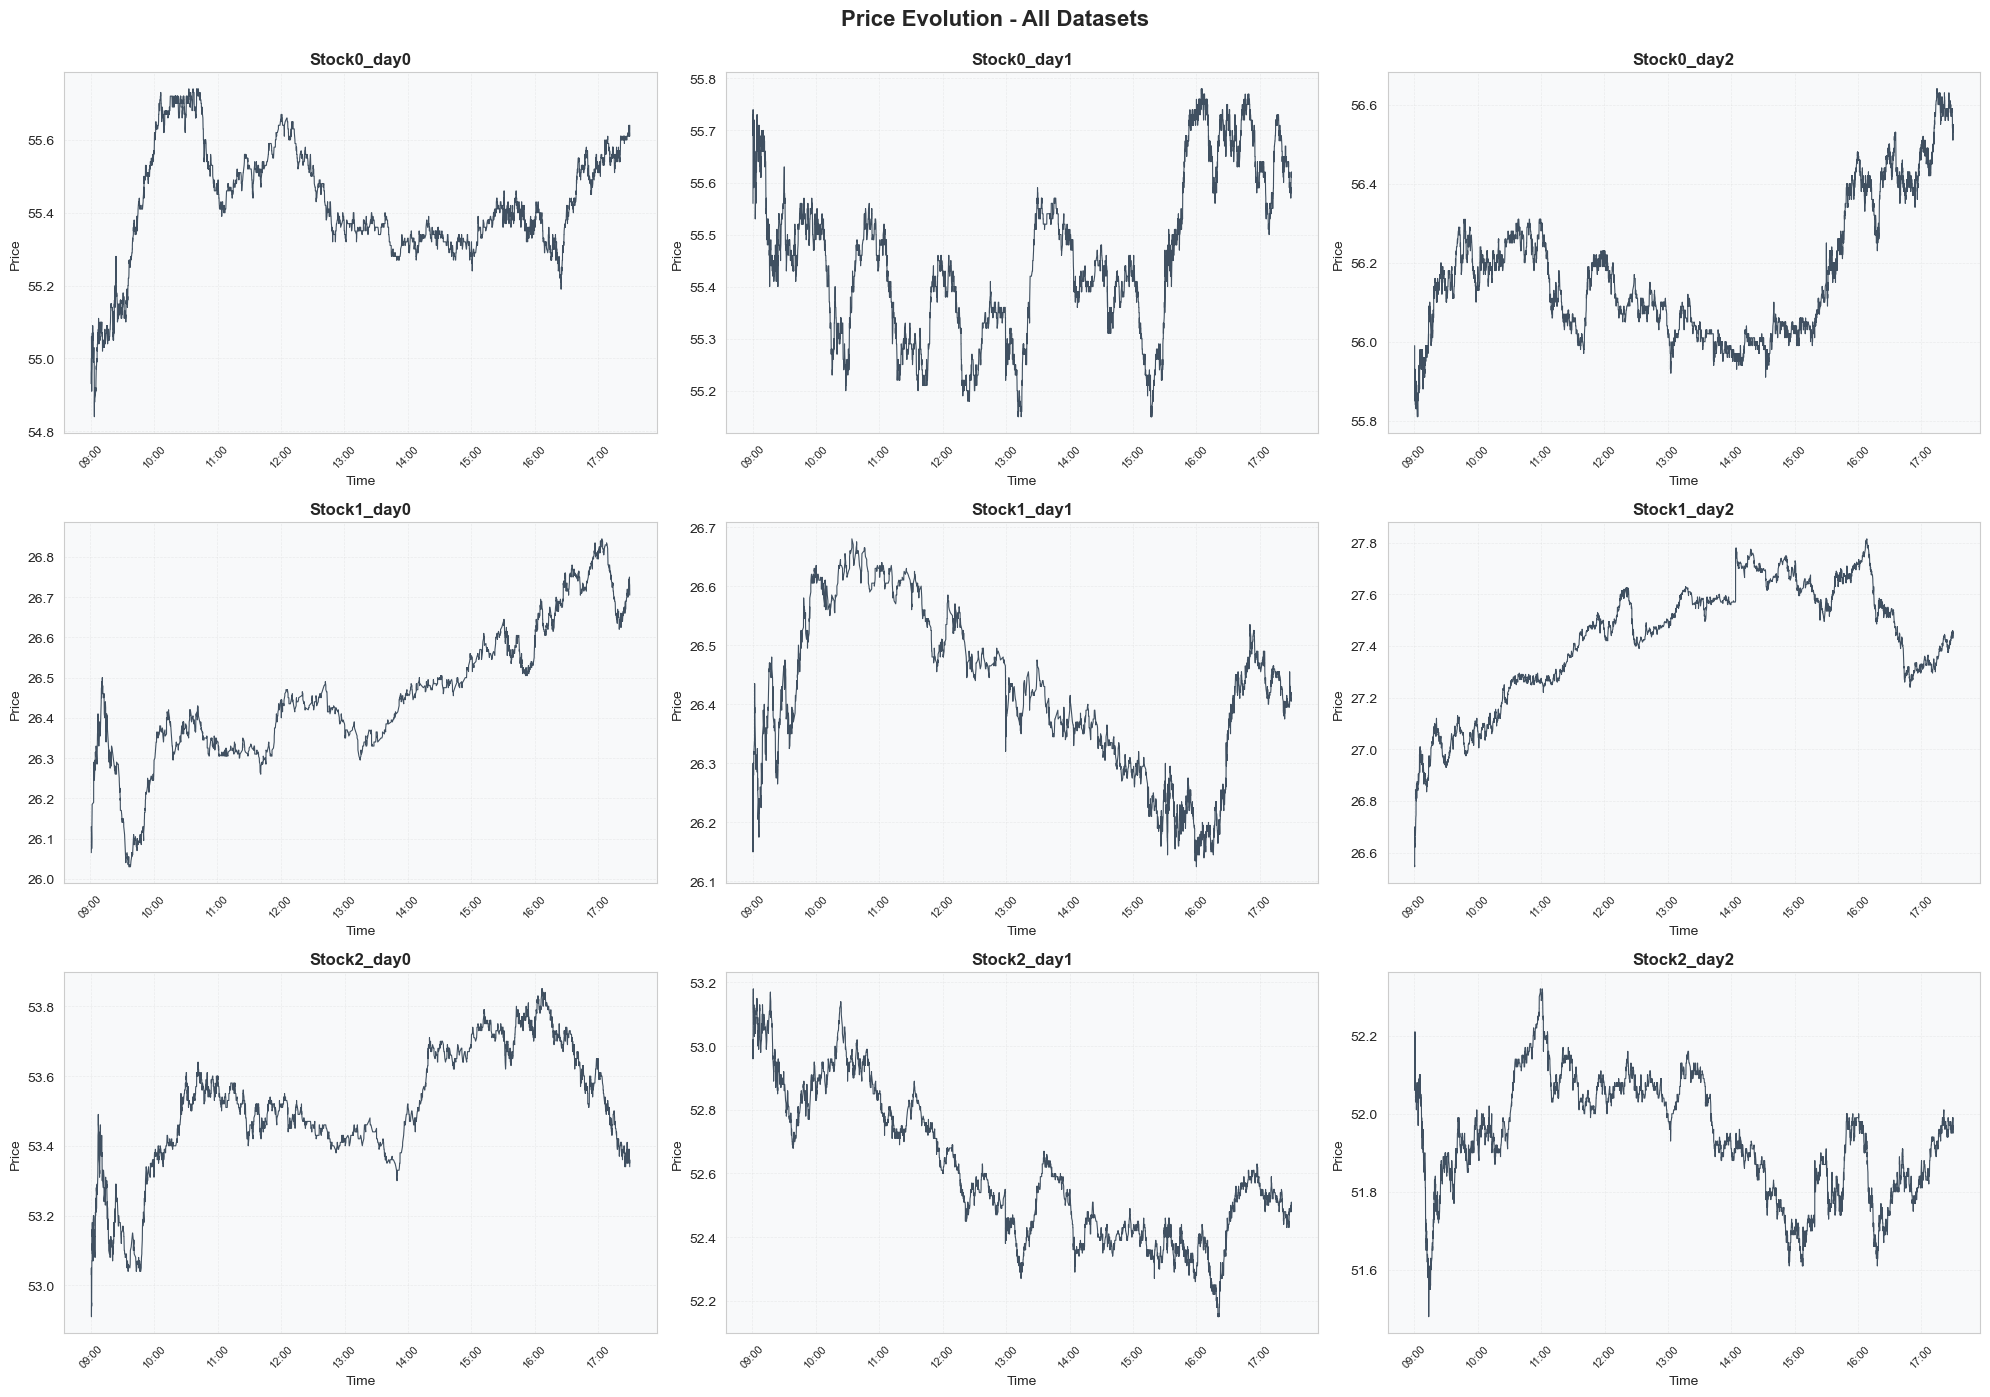

In [47]:
print("1. Évolution des prix pour tous les datasets...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'price' in df.columns:
        axes[idx].plot(df.index, df['price'], linewidth=0.8, color='#2C3E50', alpha=0.9)
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Time', fontsize=10)
        axes[idx].set_ylabel('Price', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[idx].tick_params(axis='x', rotation=45, labelsize=8)

plt.suptitle('Price Evolution - All Datasets', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

2. Distributions des prix pour tous les datasets...


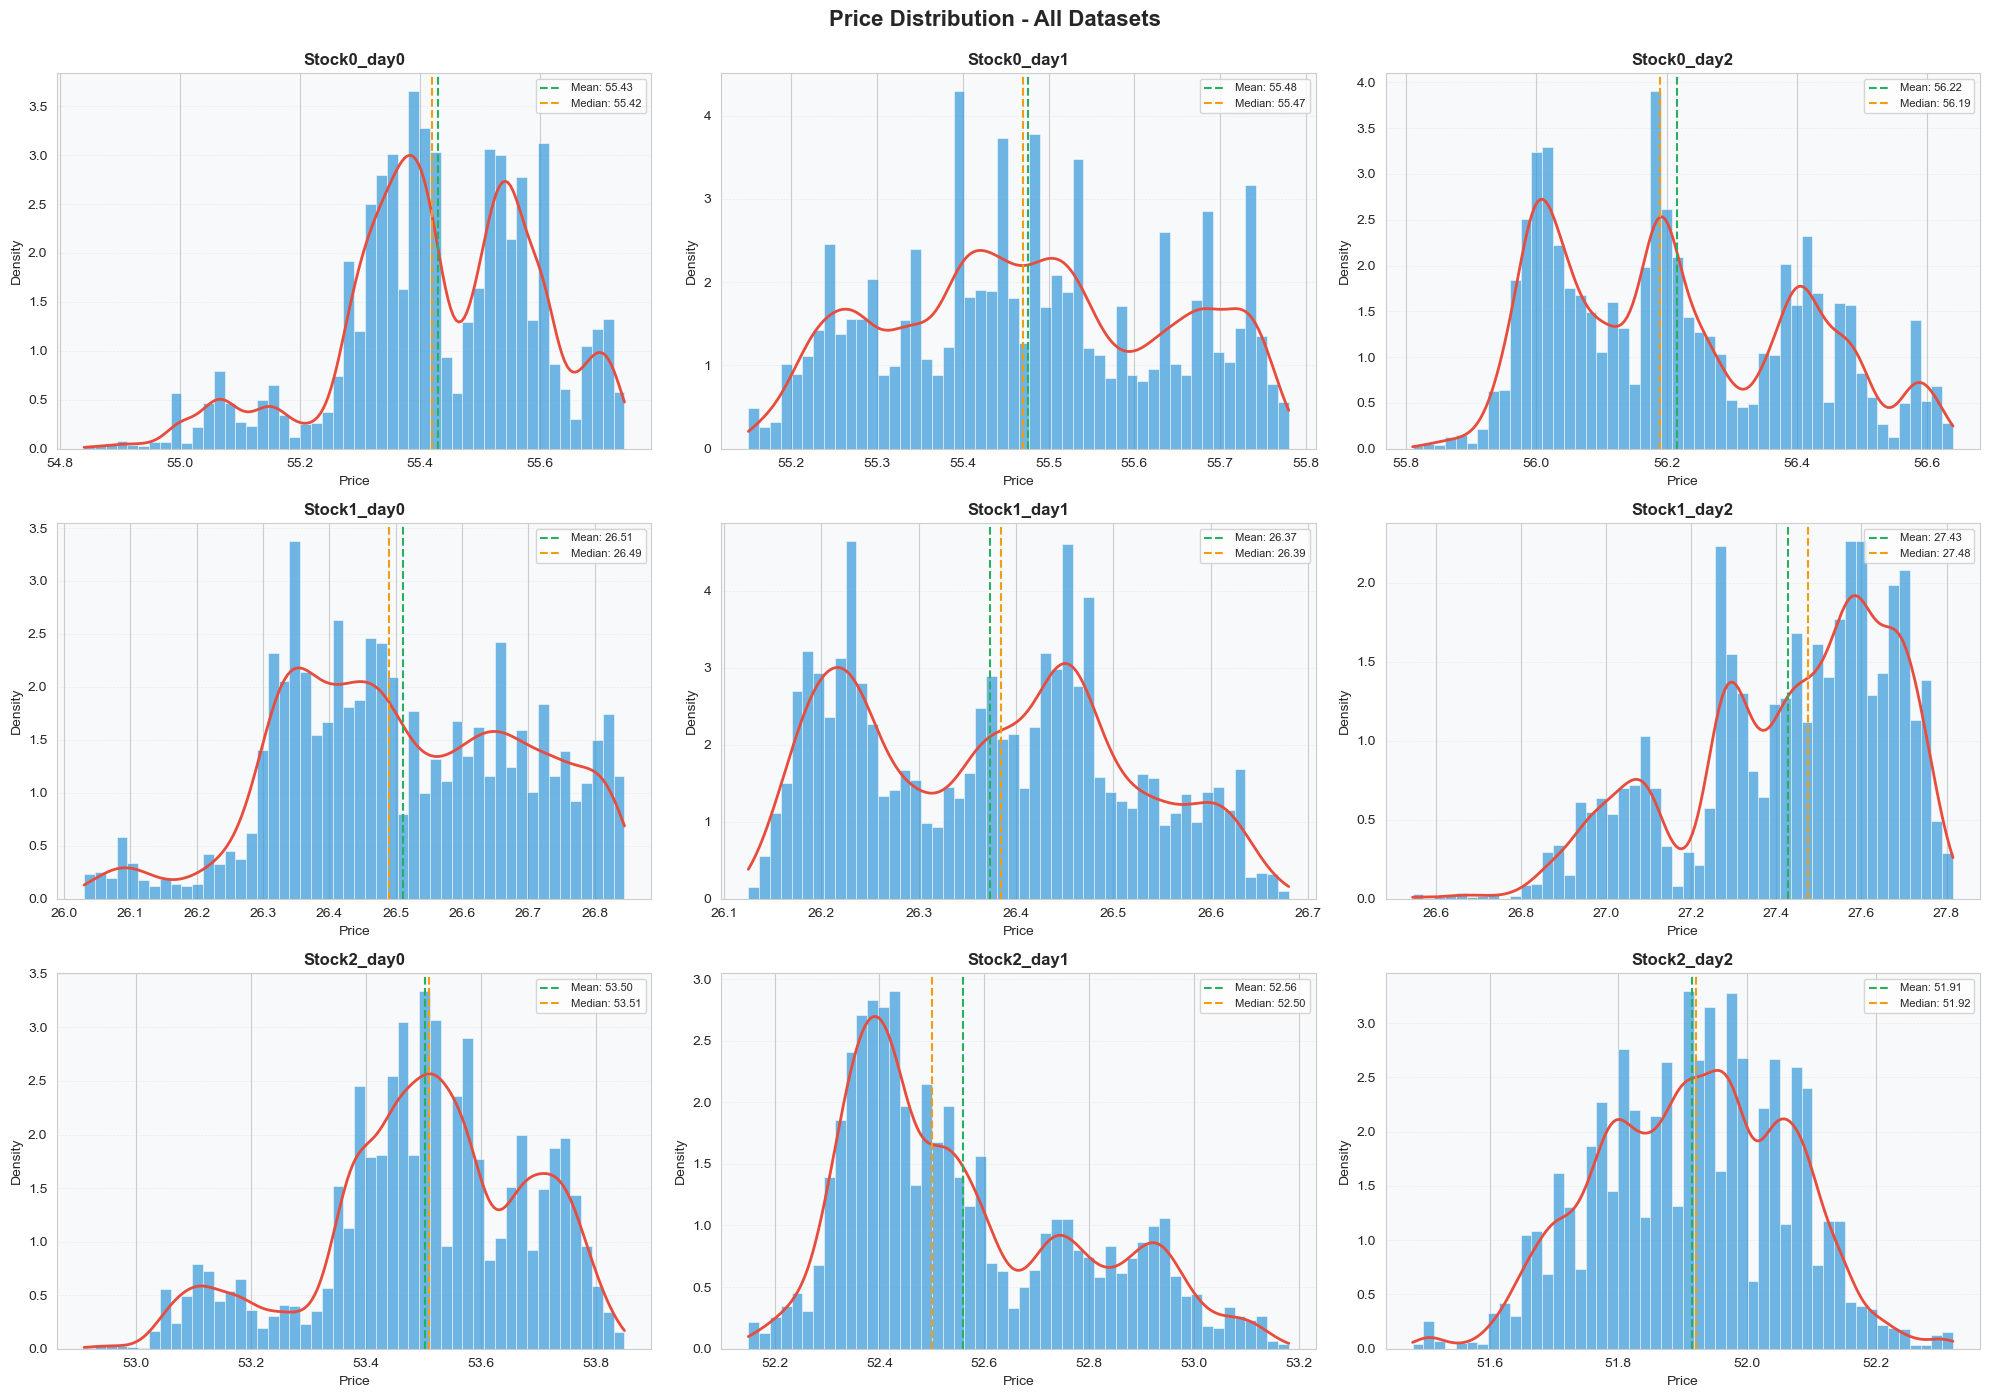

In [48]:
print("2. Distributions des prix pour tous les datasets...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'price' in df.columns:
        # Histogramme
        axes[idx].hist(df['price'], bins=50, density=True, alpha=0.7,
                      color='#3498DB', edgecolor='white', linewidth=0.5)
        
        # Kernel density
        density = stats.gaussian_kde(df['price'])
        xs = np.linspace(df['price'].min(), df['price'].max(), 200)
        axes[idx].plot(xs, density(xs), color='#E74C3C', linewidth=2)
        
        # Statistiques
        mean_price = df['price'].mean()
        median_price = df['price'].median()
        axes[idx].axvline(mean_price, color='#27AE60', linestyle='--', linewidth=1.5,
                         label=f'Mean: {mean_price:.2f}')
        axes[idx].axvline(median_price, color='#F39C12', linestyle='--', linewidth=1.5,
                         label=f'Median: {median_price:.2f}')
        
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Price', fontsize=10)
        axes[idx].set_ylabel('Density', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].legend(fontsize=8, loc='upper right')

plt.suptitle('Price Distribution - All Datasets', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

3. Distributions des quantités pour tous les datasets...


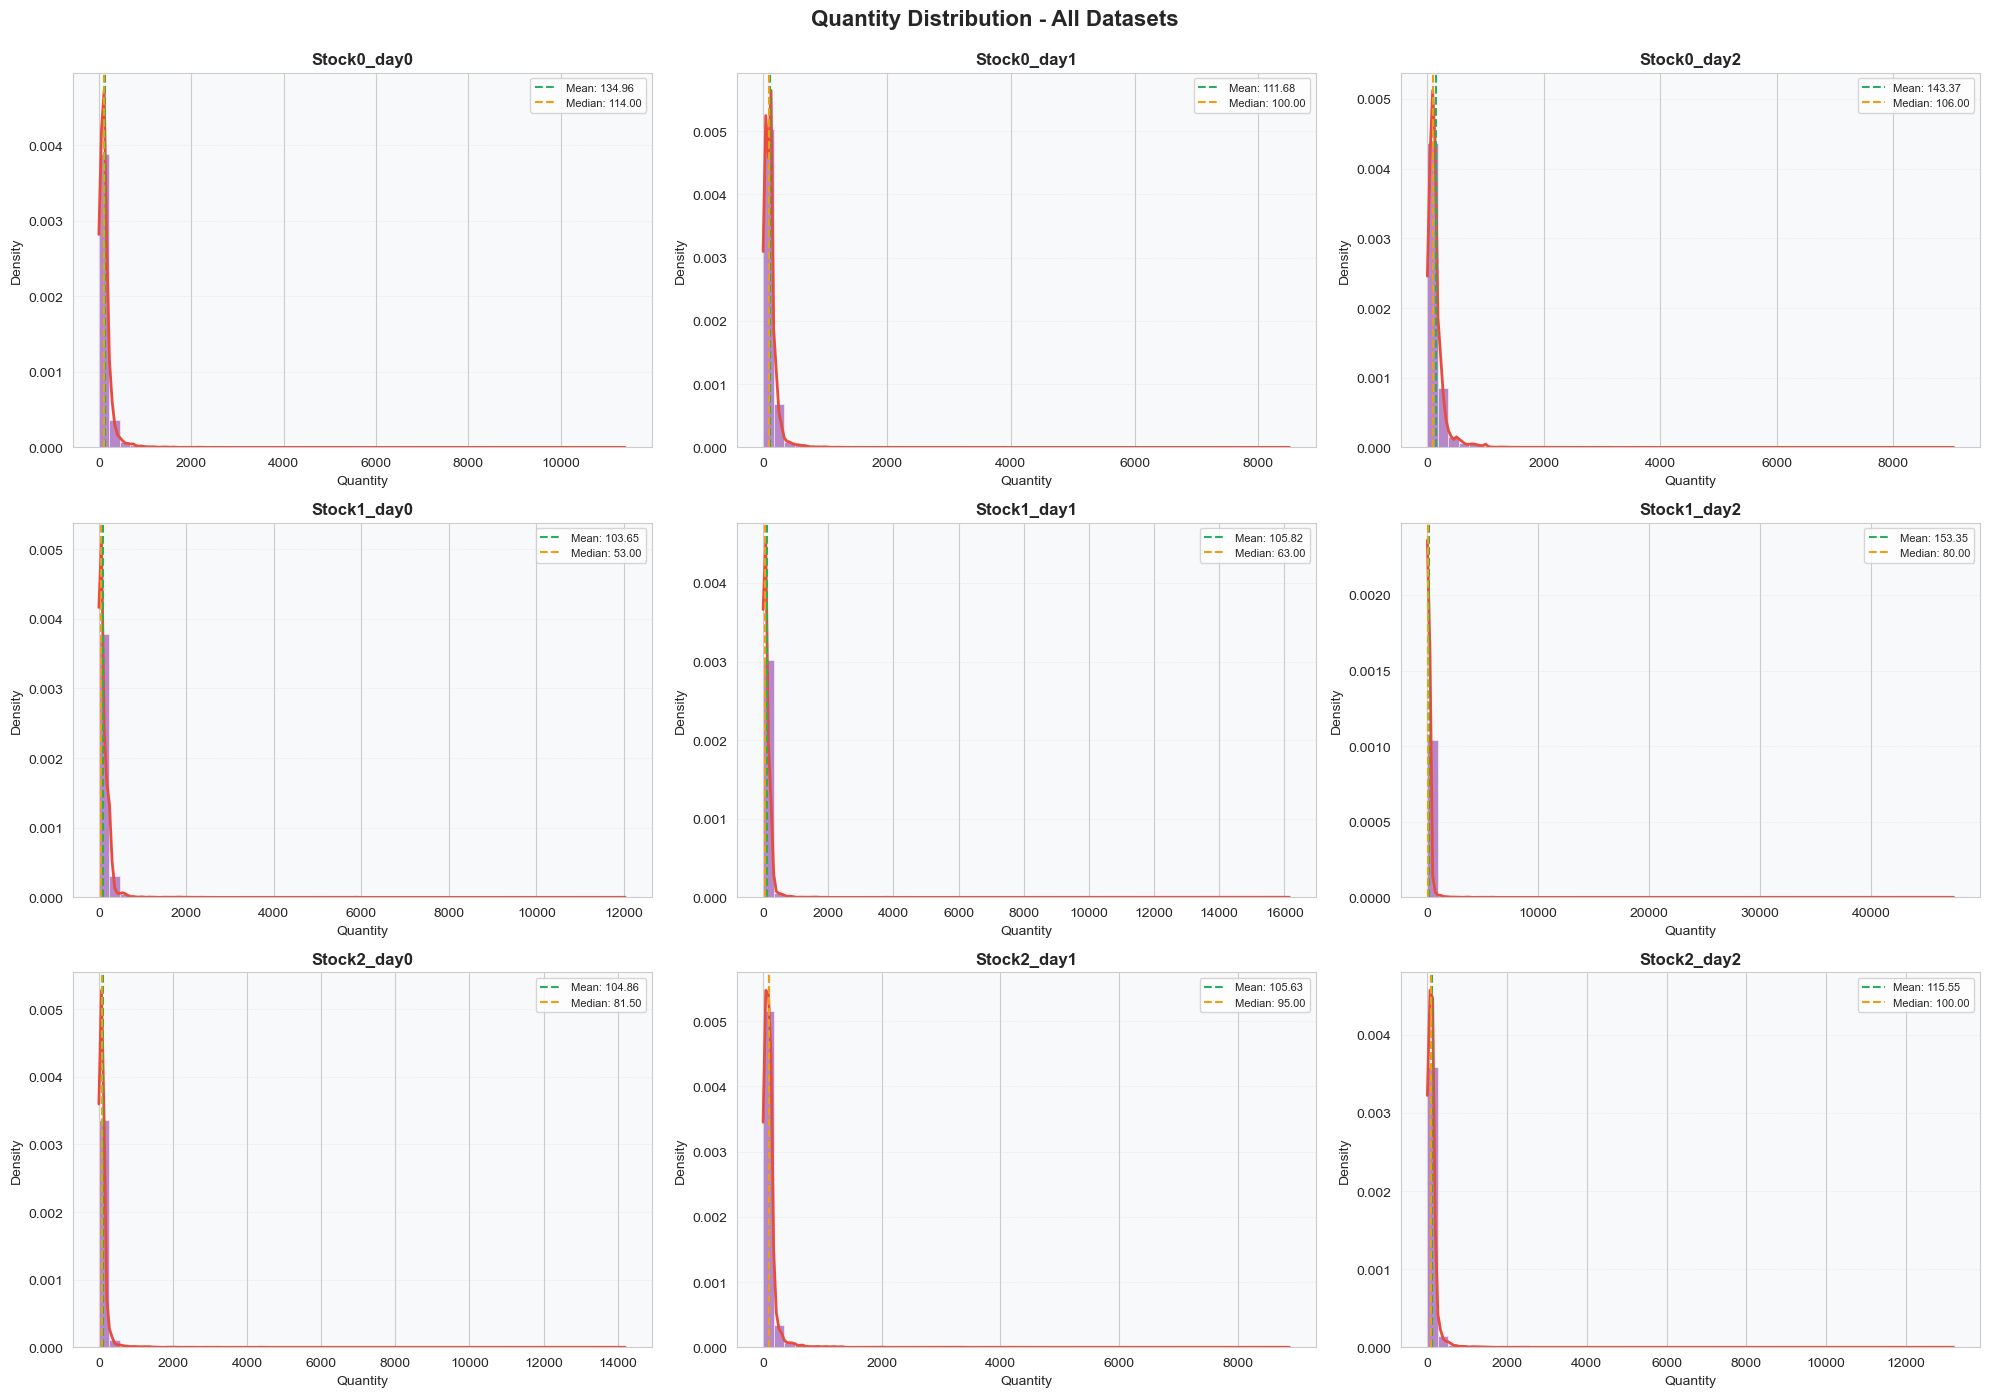

In [49]:
print("3. Distributions des quantités pour tous les datasets...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'qty' in df.columns:
        # Histogramme
        axes[idx].hist(df['qty'], bins=50, density=True, alpha=0.7,
                      color='#9B59B6', edgecolor='white', linewidth=0.5)
        
        # Kernel density
        density = stats.gaussian_kde(df['qty'])
        xs = np.linspace(df['qty'].min(), df['qty'].max(), 200)
        axes[idx].plot(xs, density(xs), color='#E74C3C', linewidth=2)
        
        # Statistiques
        mean_qty = df['qty'].mean()
        median_qty = df['qty'].median()
        axes[idx].axvline(mean_qty, color='#27AE60', linestyle='--', linewidth=1.5,
                         label=f'Mean: {mean_qty:.2f}')
        axes[idx].axvline(median_qty, color='#F39C12', linestyle='--', linewidth=1.5,
                         label=f'Median: {median_qty:.2f}')
        
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Quantity', fontsize=10)
        axes[idx].set_ylabel('Density', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].legend(fontsize=8, loc='upper right')

plt.suptitle('Quantity Distribution - All Datasets', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [50]:
print("\n4. Statistiques récapitulatives des prix:")

price_stats = []
for name, df in all_dfs.items():
    if 'price' in df.columns:
        stats = {
            'Dataset': name,
            'Mean': f"{df['price'].mean():.4f}",
            'Median': f"{df['price'].median():.4f}",
            'Std': f"{df['price'].std():.4f}",
            'Min': f"{df['price'].min():.4f}",
            'Max': f"{df['price'].max():.4f}",
            'Skewness': f"{df['price'].skew():.4f}",
            'Kurtosis': f"{df['price'].kurtosis():.4f}"
        }
        price_stats.append(stats)

price_stats_df = pd.DataFrame(price_stats)
print(price_stats_df.to_string(index=False))


4. Statistiques récapitulatives des prix:
    Dataset    Mean  Median    Std     Min     Max Skewness Kurtosis
Stock0_day0 55.4301 55.4200 0.1654 54.8400 55.7400  -0.5435   0.2436
Stock0_day1 55.4764 55.4700 0.1610 55.1500 55.7800   0.0428  -1.0016
Stock0_day2 56.2169 56.1900 0.1900 55.8100 56.6400   0.3586  -0.9620
Stock1_day0 26.5116 26.4900 0.1831 26.0300 26.8450  -0.0829  -0.6311
Stock1_day1 26.3732 26.3850 0.1384 26.1250 26.6800   0.1223  -1.0911
Stock1_day2 27.4264 27.4750 0.2442 26.5450 27.8150  -0.6761  -0.3557
Stock2_day0 53.5026 53.5100 0.1819 52.9100 53.8500  -0.5526  -0.0090
Stock2_day1 52.5595 52.5000 0.2240 52.1500 53.1800   0.7032  -0.5151
Stock2_day2 51.9144 51.9200 0.1468 51.4800 52.3200  -0.0949  -0.4377


In [54]:
print("\n5. Statistiques récapitulatives des quantités:")

qty_stats = []
for name, df in all_dfs.items():
    if 'qty' in df.columns:
        stats = {
            'Dataset': name,
            'Mean': f"{df['qty'].mean():.4f}",
            'Median': f"{df['qty'].median():.4f}",
            'Std': f"{df['qty'].std():.4f}",
            'Min': f"{df['qty'].min():.4f}",
            'Max': f"{df['qty'].max():.4f}",
            'Skewness': f"{df['qty'].skew():.4f}",
            'Kurtosis': f"{df['qty'].kurtosis():.4f}"
        }
        qty_stats.append(stats)

qty_stats_df = pd.DataFrame(qty_stats)
print(qty_stats_df.to_string(index=False))


5. Statistiques récapitulatives des quantités:
    Dataset     Mean   Median      Std    Min        Max Skewness  Kurtosis
Stock0_day0 134.9613 114.0000 231.6046 1.0000 11400.0000  20.9443  744.4865
Stock0_day1 111.6813 100.0000 174.1195 1.0000  8500.0000  23.4408  881.4031
Stock0_day2 143.3657 106.0000 220.0030 1.0000  9042.0000  14.0604  372.1328
Stock1_day0 103.6491  53.0000 233.5950 1.0000 12031.0000  31.3620 1462.7883
Stock1_day1 105.8199  63.0000 270.4308 1.0000 16153.0000  39.6534 2171.0920
Stock1_day2 153.3522  80.0000 606.9358 1.0000 47478.0000  52.7307 3790.6241
Stock2_day0 104.8615  81.5000 269.6994 1.0000 14203.0000  27.1148 1106.4344
Stock2_day1 105.6340  95.0000 195.3067 1.0000  8871.0000  19.3753  626.0143
Stock2_day2 115.5536 100.0000 237.1586 1.0000 13197.0000  29.9256 1330.1018


In [43]:
print(f"\n{'='*70}")
print(f"RÉSUMÉ COMPARATIF - TOUS LES DATASETS")
print(f"{'='*70}\n")

summary = []
for name, df in all_dfs.items():
    stats_dict = {
        'Dataset': name,
        'Trades': f"{len(df):,}",
        'Missing': df.isna().sum().sum(),
        'Duplicates': df.duplicated().sum()
    }
    
    if 'price' in df.columns:
        stats_dict['Mean_Price'] = f"{df['price'].mean():.4f}"
        stats_dict['Std_Price'] = f"{df['price'].std():.4f}"
    
    if 'qty' in df.columns:
        stats_dict['Mean_Qty'] = f"{df['qty'].mean():.2f}"
        stats_dict['Total_Qty'] = f"{df['qty'].sum():.0f}"
    
    summary.append(stats_dict)

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))


RÉSUMÉ COMPARATIF - TOUS LES DATASETS

    Dataset Trades  Missing  Duplicates Mean_Price Std_Price Mean_Qty Total_Qty
Stock0_day0 19,076        0       10917    55.4301    0.1654   134.96   2574521
Stock0_day1 21,933        0       13301    55.4764    0.1610   111.68   2449507
Stock0_day2 30,315        0       18679    56.2169    0.1900   143.37   4346132
Stock1_day0  4,927        0         966    26.5116    0.1831   103.65    510679
Stock1_day1  5,941        0        1772    26.3732    0.1384   105.82    628676
Stock1_day2 10,144        0        2443    27.4264    0.2442   153.35   1555605
Stock2_day0  9,500        0        4923    53.5026    0.1819   104.86    996184
Stock2_day1 11,466        0        5780    52.5595    0.2240   105.63   1211200
Stock2_day2 13,178        0        6960    51.9144    0.1468   115.55   1522765



6. Évolution des prix par stock (tous jours agrégés)...


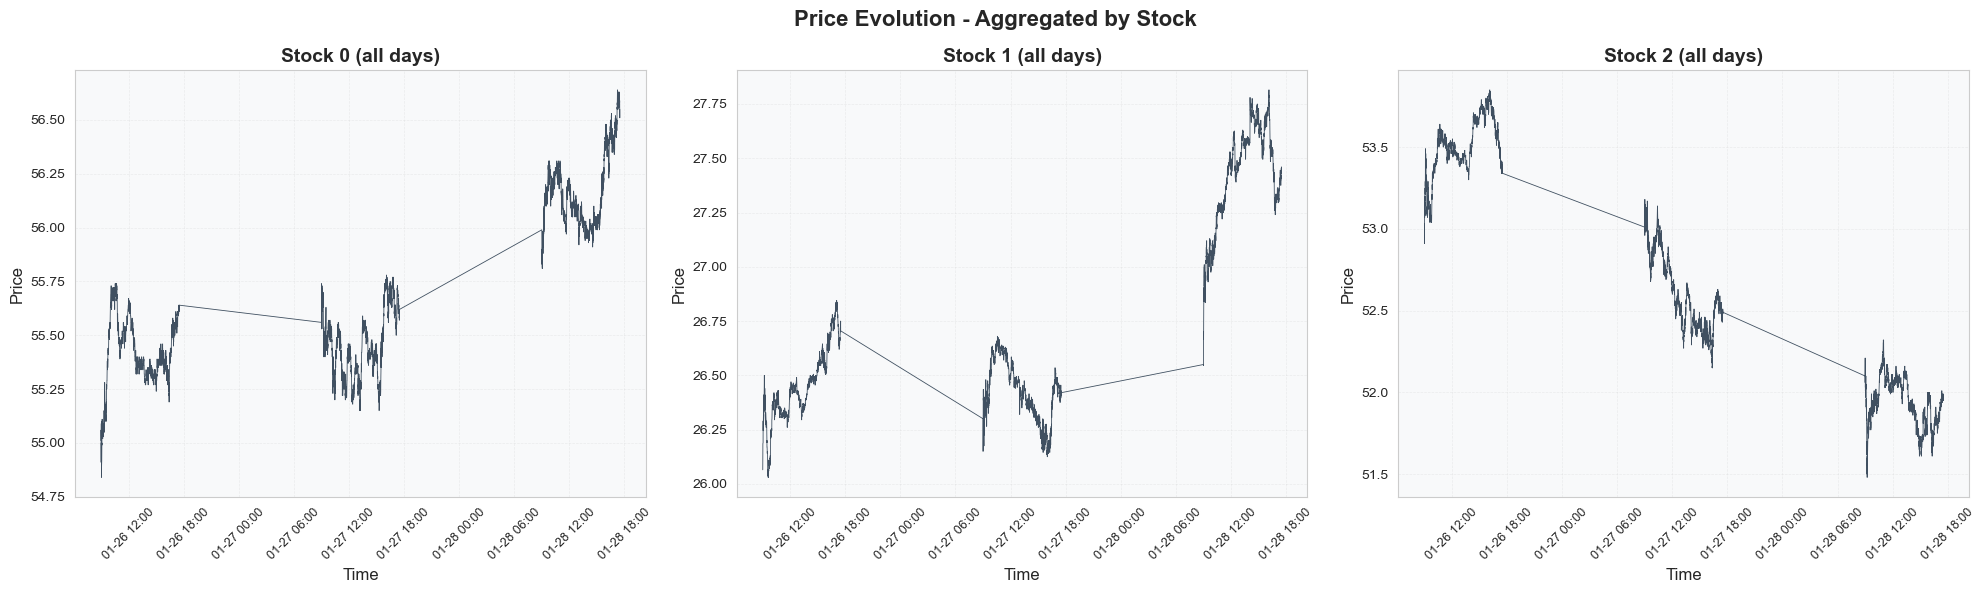

In [56]:
print("\n6. Évolution des prix par stock (tous jours agrégés)...")

# Agréger par stock
stock0_all = pd.concat([df0_j0, df0_j1, df0_j2]).sort_index()
stock1_all = pd.concat([df1_j0, df1_j1, df1_j2]).sort_index()
stock2_all = pd.concat([df2_j0, df2_j1, df2_j2]).sort_index()

stocks_aggregated = {
    'Stock 0 (all days)': stock0_all,
    'Stock 1 (all days)': stock1_all,
    'Stock 2 (all days)': stock2_all
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (stock_name, df) in enumerate(stocks_aggregated.items()):
    if 'price' in df.columns:
        axes[idx].plot(df.index, df['price'], linewidth=0.6, color='#2C3E50', alpha=0.9)
        axes[idx].set_title(f'{stock_name}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Time', fontsize=12)
        axes[idx].set_ylabel('Price', fontsize=12)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        axes[idx].tick_params(axis='x', rotation=45, labelsize=9)

plt.suptitle('Price Evolution - Aggregated by Stock', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [53]:
print(f"\n{'='*70}")
print(f"RÉSUMÉ COMPARATIF - TOUS LES DATASETS")
print(f"{'='*70}\n")

summary = []
for name, df in all_dfs.items():
    stats_dict = {
        'Dataset': name,
        'Trades': f"{len(df):,}",
        'Missing': df.isna().sum().sum(),
        'Duplicates': df.duplicated().sum()
    }
    
    if 'price' in df.columns:
        stats_dict['Mean_Price'] = f"{df['price'].mean():.4f}"
        stats_dict['Std_Price'] = f"{df['price'].std():.4f}"
    
    if 'qty' in df.columns:
        stats_dict['Mean_Qty'] = f"{df['qty'].mean():.2f}"
        stats_dict['Total_Qty'] = f"{df['qty'].sum():.0f}"
    
    summary.append(stats_dict)

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))


RÉSUMÉ COMPARATIF - TOUS LES DATASETS

    Dataset Trades  Missing  Duplicates Mean_Price Std_Price Mean_Qty Total_Qty
Stock0_day0 19,076        0       10917    55.4301    0.1654   134.96   2574521
Stock0_day1 21,933        0       13301    55.4764    0.1610   111.68   2449507
Stock0_day2 30,315        0       18679    56.2169    0.1900   143.37   4346132
Stock1_day0  4,927        0         966    26.5116    0.1831   103.65    510679
Stock1_day1  5,941        0        1772    26.3732    0.1384   105.82    628676
Stock1_day2 10,144        0        2443    27.4264    0.2442   153.35   1555605
Stock2_day0  9,500        0        4923    53.5026    0.1819   104.86    996184
Stock2_day1 11,466        0        5780    52.5595    0.2240   105.63   1211200
Stock2_day2 13,178        0        6960    51.9144    0.1468   115.55   1522765


In [44]:
print(f"\n{'='*70}")
print(f"COMPARAISON PAR STOCK (tous jours agrégés)")
print(f"{'='*70}\n")

# Agréger par stock
stock0_all = pd.concat([df0_j0, df0_j1, df0_j2]).sort_index()
stock1_all = pd.concat([df1_j0, df1_j1, df1_j2]).sort_index()
stock2_all = pd.concat([df2_j0, df2_j1, df2_j2]).sort_index()

stocks_aggregated = {
    'Stock0': stock0_all,
    'Stock1': stock1_all,
    'Stock2': stock2_all
}

for stock_name, df in stocks_aggregated.items():
    print(f"\n{stock_name}:")
    print(f"  Total trades: {len(df):,}")
    
    if 'price' in df.columns:
        print(f"  Prix moyen: {df['price'].mean():.4f}")
        print(f"  Prix std: {df['price'].std():.4f}")
        print(f"  Prix min: {df['price'].min():.4f}")
        print(f"  Prix max: {df['price'].max():.4f}")
    
    if 'qty' in df.columns:
        print(f"  Quantité moyenne: {df['qty'].mean():.2f}")
        print(f"  Quantité totale: {df['qty'].sum():.0f}")


COMPARAISON PAR STOCK (tous jours agrégés)


Stock0:
  Total trades: 71,324
  Prix moyen: 55.7788
  Prix std: 0.4157
  Prix min: 54.8400
  Prix max: 56.6400
  Quantité moyenne: 131.37
  Quantité totale: 9370160

Stock1:
  Total trades: 21,012
  Prix moyen: 26.9141
  Prix std: 0.5381
  Prix min: 26.0300
  Prix max: 27.8150
  Quantité moyenne: 128.26
  Quantité totale: 2694960

Stock2:
  Total trades: 34,144
  Prix moyen: 52.5729
  Prix std: 0.6650
  Prix min: 51.4800
  Prix max: 53.8500
  Quantité moyenne: 109.25
  Quantité totale: 3730149


## 1.2 Tick size

Tick size is defined as the minimum increment in the price of an asset

In [25]:
tick_size = df0['price'].diff().abs().replace(0, np.nan).min()
print(f"Tick size: {tick_size}")

Tick size: 0.00999999999999801


To verify if we computed the right number we check that all prices variations are multiple of the tick

In [26]:
price_changes = df0['price'].diff().dropna()
non_zero_changes = price_changes[price_changes != 0]

multiples = non_zero_changes / tick_size
is_valid = np.allclose(multiples, multiples.round(), rtol=1e-5)

print(f"Tick size valide: {is_valid}")
print(f"Exemples de multiples: {multiples.head()}")

Tick size valide: True
Exemples de multiples: ts
2026-01-26 09:00:27.041728   -3.0
2026-01-26 09:00:27.072145   -2.0
2026-01-26 09:00:27.085654    2.0
2026-01-26 09:00:27.336066   -1.0
2026-01-26 09:00:27.336175   -1.0
Name: price, dtype: float64


## 1.3 Intraday activity

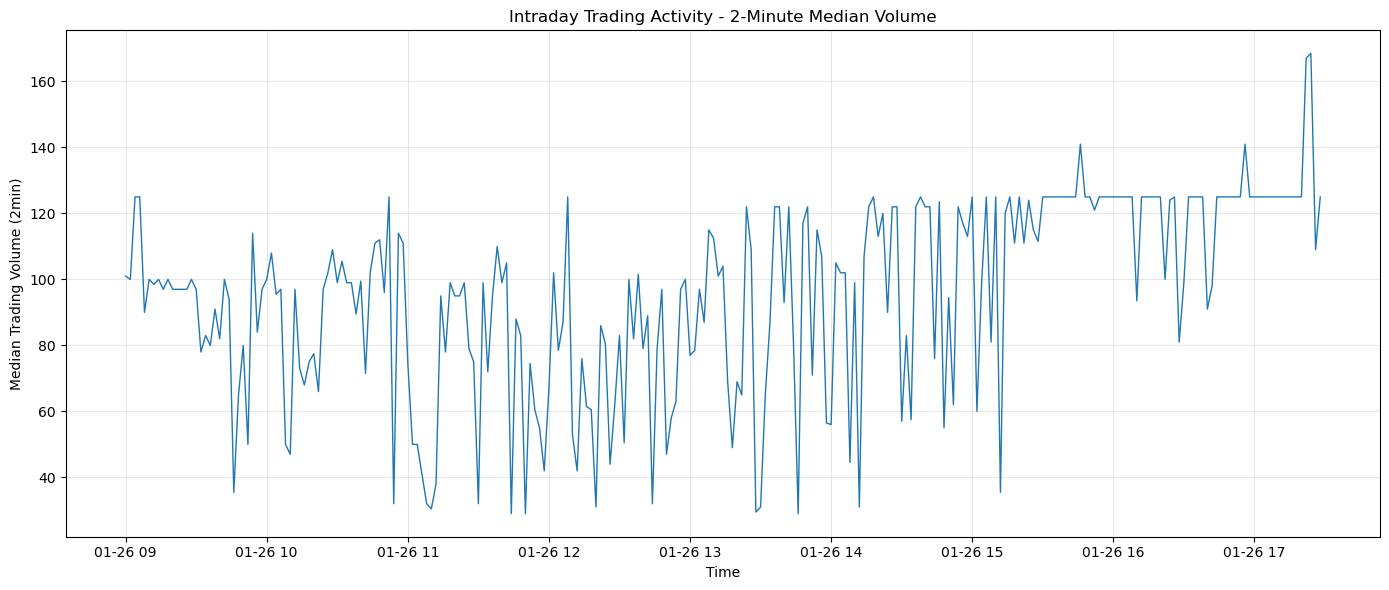

In [27]:
volume_2min = df0['qty'].resample('2min').median()

plt.figure(figsize=(14, 6))
plt.plot(volume_2min.index, volume_2min.values, linewidth=1)
plt.xlabel('Time')
plt.ylabel('Median Trading Volume (2min)')
plt.title('Intraday Trading Activity - 2-Minute Median Volume')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

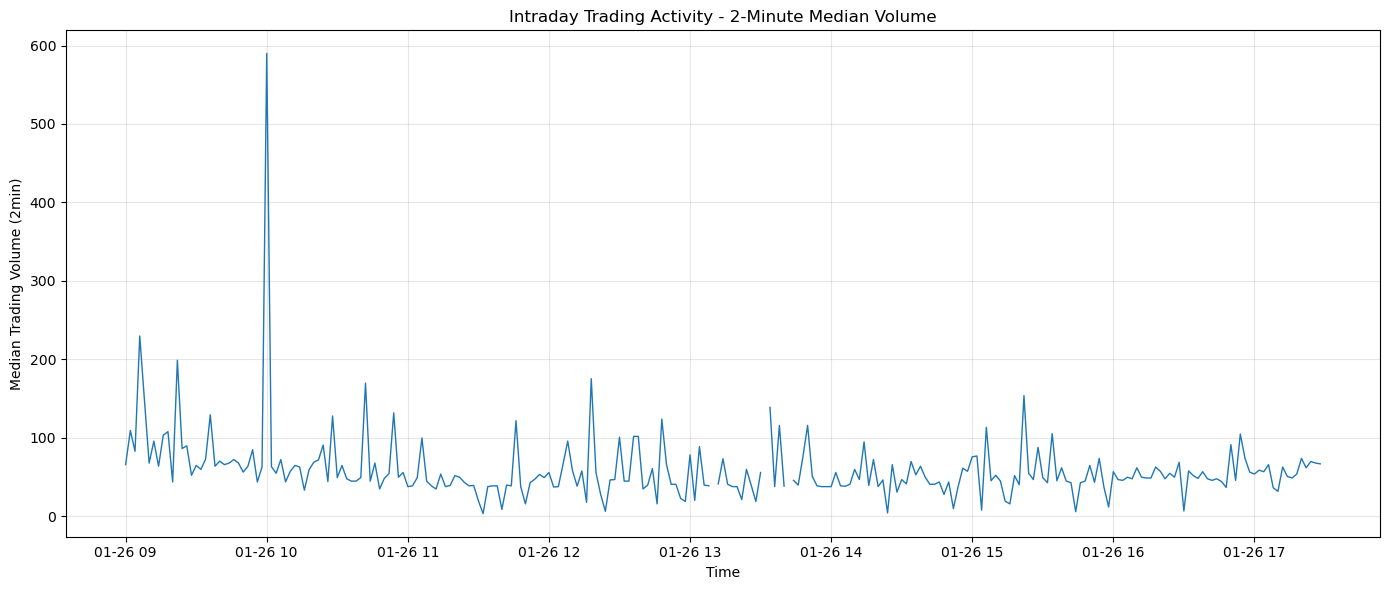

In [28]:
volume_2min = df2['qty'].resample('2min').median()

plt.figure(figsize=(14, 6))
plt.plot(volume_2min.index, volume_2min.values, linewidth=1)
plt.xlabel('Time')
plt.ylabel('Median Trading Volume (2min)')
plt.title('Intraday Trading Activity - 2-Minute Median Volume')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

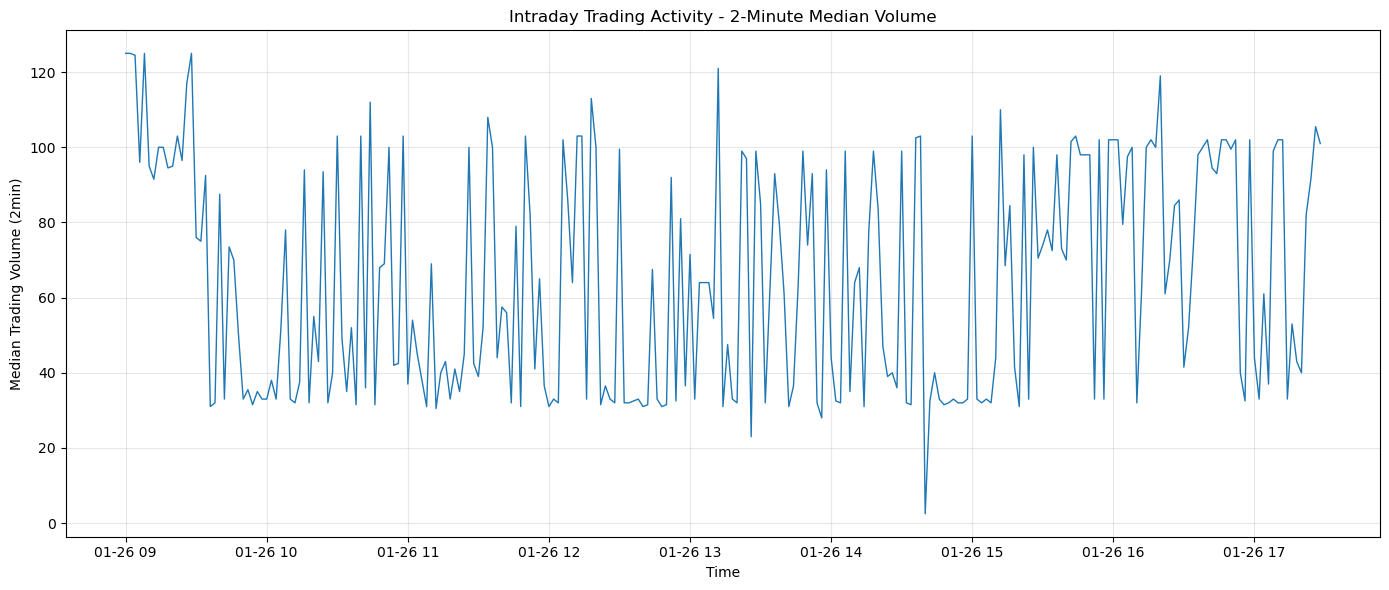

In [29]:
volume_2min = df3['qty'].resample('2min').median()

plt.figure(figsize=(14, 6))
plt.plot(volume_2min.index, volume_2min.values, linewidth=1)
plt.xlabel('Time')
plt.ylabel('Median Trading Volume (2min)')
plt.title('Intraday Trading Activity - 2-Minute Median Volume')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We see that the curve depend on the stock. We do not clearly retrieve the U-Shape expected and for european stock we do not clearly see the opening of American Market

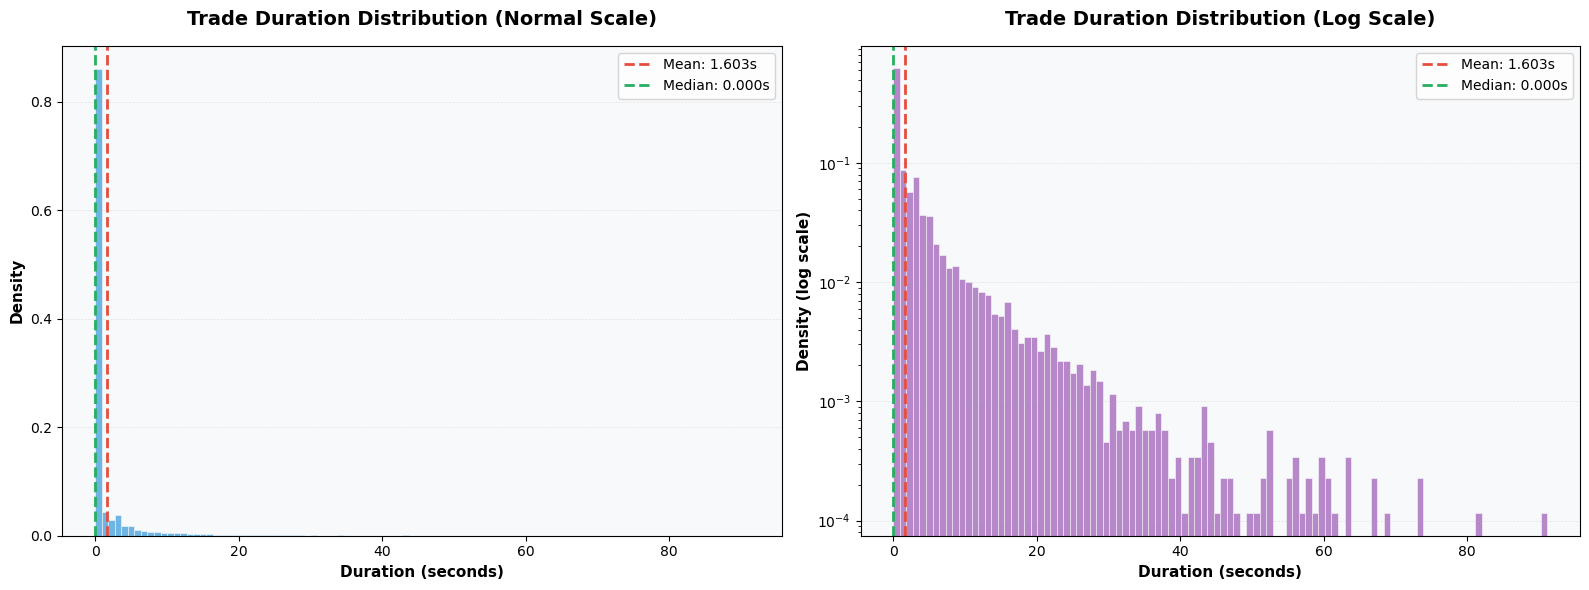

=== Trade Duration Statistics ===
Mean: 1.602709 seconds
Median: 0.000008 seconds
Std: 5.077909 seconds
Min: 0.000000 seconds
Max: 91.165176 seconds

Quantiles:
0.25     0.000000
0.50     0.000008
0.75     0.334105
0.95     9.511165
0.99    25.061209
Name: ts, dtype: float64


In [30]:
trade_durations = df0.index.to_series().diff().dt.total_seconds()
trade_durations = trade_durations.dropna()  

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(trade_durations, bins=100, density=True, 
             alpha=0.7, color='#3498DB', edgecolor='white', linewidth=0.5)

mean_duration = trade_durations.mean()
median_duration = trade_durations.median()
axes[0].axvline(mean_duration, color='#E74C3C', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_duration:.3f}s')
axes[0].axvline(median_duration, color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Median: {median_duration:.3f}s')

axes[0].set_title('Trade Duration Distribution (Normal Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Duration (seconds)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[0].set_facecolor('#F8F9FA')
axes[0].legend(fontsize=10)

trade_durations_pos = trade_durations[trade_durations > 0]

axes[1].hist(trade_durations_pos, bins=100, density=True, 
             alpha=0.7, color='#9B59B6', edgecolor='white', linewidth=0.5)
axes[1].set_yscale('log')

axes[1].axvline(mean_duration, color='#E74C3C', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_duration:.3f}s')
axes[1].axvline(median_duration, color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Median: {median_duration:.3f}s')

axes[1].set_title('Trade Duration Distribution (Log Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Duration (seconds)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Density (log scale)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[1].set_facecolor('#F8F9FA')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("=== Trade Duration Statistics ===")
print(f"Mean: {mean_duration:.6f} seconds")
print(f"Median: {median_duration:.6f} seconds")
print(f"Std: {trade_durations.std():.6f} seconds")
print(f"Min: {trade_durations.min():.6f} seconds")
print(f"Max: {trade_durations.max():.6f} seconds")
print(f"\nQuantiles:")
print(trade_durations.quantile([0.25, 0.5, 0.75, 0.95, 0.99]))

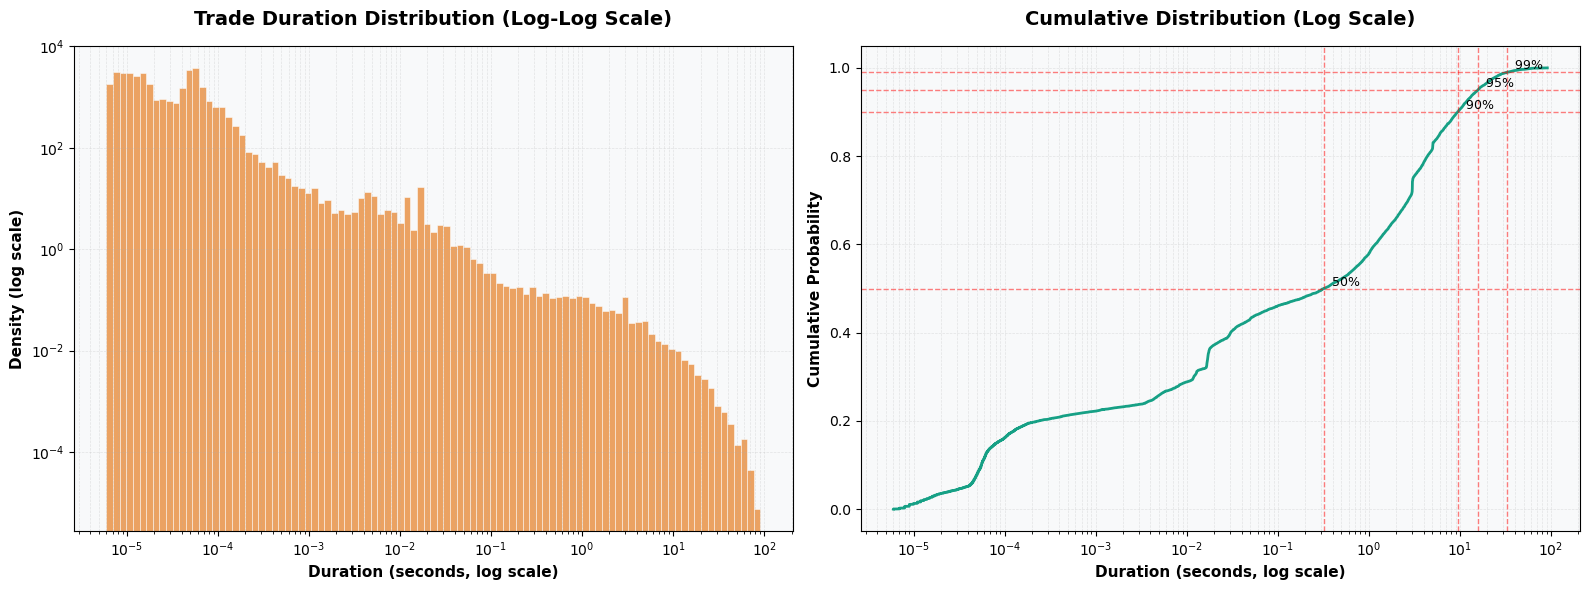

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

trade_durations_pos = trade_durations[trade_durations > 0]

axes[0].hist(trade_durations_pos, bins=np.logspace(np.log10(trade_durations_pos.min()),
                                                     np.log10(trade_durations_pos.max()), 
                                                     100),
             density=True, alpha=0.7, color='#E67E22', edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Trade Duration Distribution (Log-Log Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Duration (seconds, log scale)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Density (log scale)', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, which='both', linestyle='--', linewidth=0.5)
axes[0].set_facecolor('#F8F9FA')

sorted_durations = np.sort(trade_durations_pos)
cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

axes[1].plot(sorted_durations, cumulative, linewidth=2, color='#16A085')
axes[1].set_xscale('log')
axes[1].set_title('Cumulative Distribution (Log Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Duration (seconds, log scale)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, which='both', linestyle='--', linewidth=0.5)
axes[1].set_facecolor('#F8F9FA')

for p in [0.5, 0.9, 0.95, 0.99]:
    val = np.percentile(sorted_durations, p * 100)
    axes[1].axhline(p, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[1].axvline(val, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[1].text(val, p, f'  {p*100:.0f}%', fontsize=9, va='bottom')

plt.tight_layout()
plt.show()

Lambda (MLE): 0.007410
Mean volume: 134.96


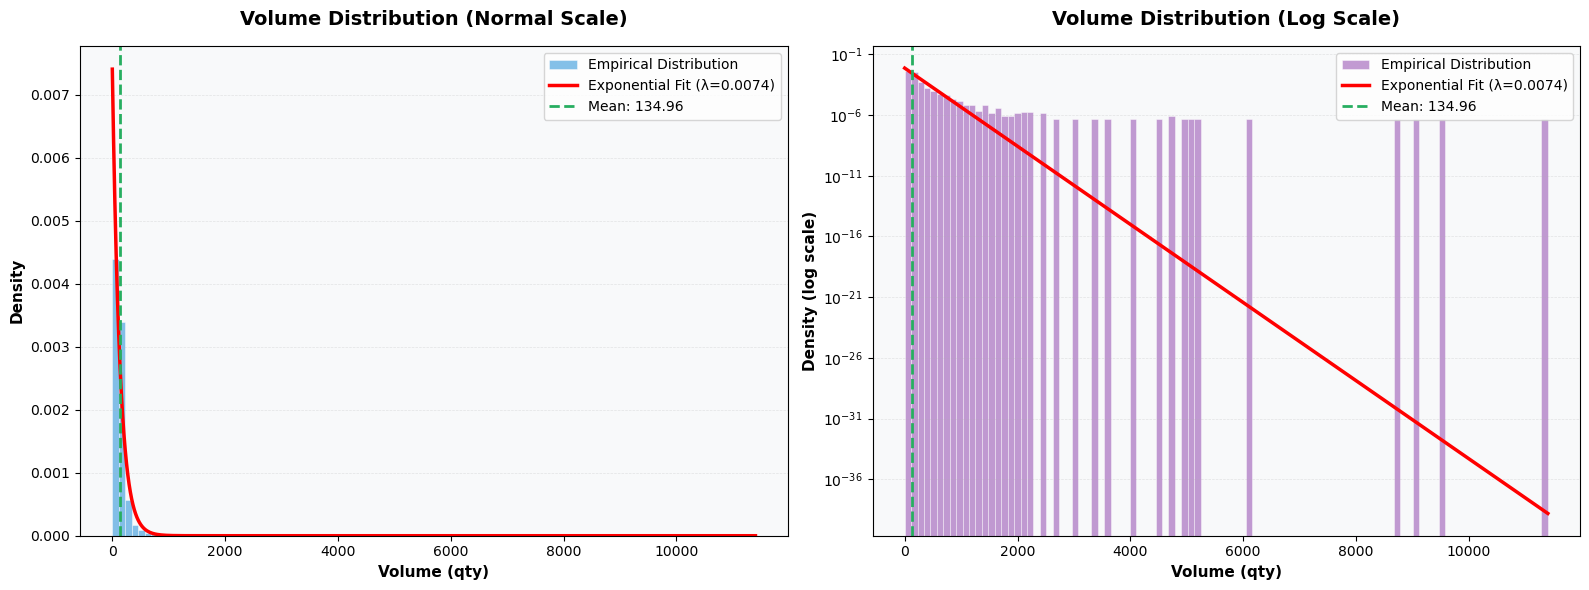

In [32]:
def exponential_func(x, lamb, scale):
    return scale * lamb * np.exp(-lamb * x)

volumes = df0['qty'].dropna()
volumes_pos = volumes[volumes > 0] 

lamb_mle = 1 / volumes_pos.mean()  
print(f"Lambda (MLE): {lamb_mle:.6f}")
print(f"Mean volume: {volumes_pos.mean():.2f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

n, bins, patches = axes[0].hist(volumes_pos, bins=100, density=True, 
                                 alpha=0.6, color='#3498DB', 
                                 edgecolor='white', linewidth=0.5,
                                 label='Empirical Distribution')

x_range = np.linspace(0, volumes_pos.max(), 500)
exponential_fit = lamb_mle * np.exp(-lamb_mle * x_range)
axes[0].plot(x_range, exponential_fit, 'r-', linewidth=2.5, 
             label=f'Exponential Fit (λ={lamb_mle:.4f})')

axes[0].axvline(volumes_pos.mean(), color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Mean: {volumes_pos.mean():.2f}')

axes[0].set_title('Volume Distribution (Normal Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Volume (qty)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[0].set_facecolor('#F8F9FA')
axes[0].legend(fontsize=10)

axes[1].hist(volumes_pos, bins=100, density=True, 
             alpha=0.6, color='#9B59B6', 
             edgecolor='white', linewidth=0.5,
             label='Empirical Distribution')
axes[1].set_yscale('log')

axes[1].plot(x_range, exponential_fit, 'r-', linewidth=2.5, 
             label=f'Exponential Fit (λ={lamb_mle:.4f})')

axes[1].axvline(volumes_pos.mean(), color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Mean: {volumes_pos.mean():.2f}')

axes[1].set_title('Volume Distribution (Log Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Volume (qty)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Density (log scale)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[1].set_facecolor('#F8F9FA')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

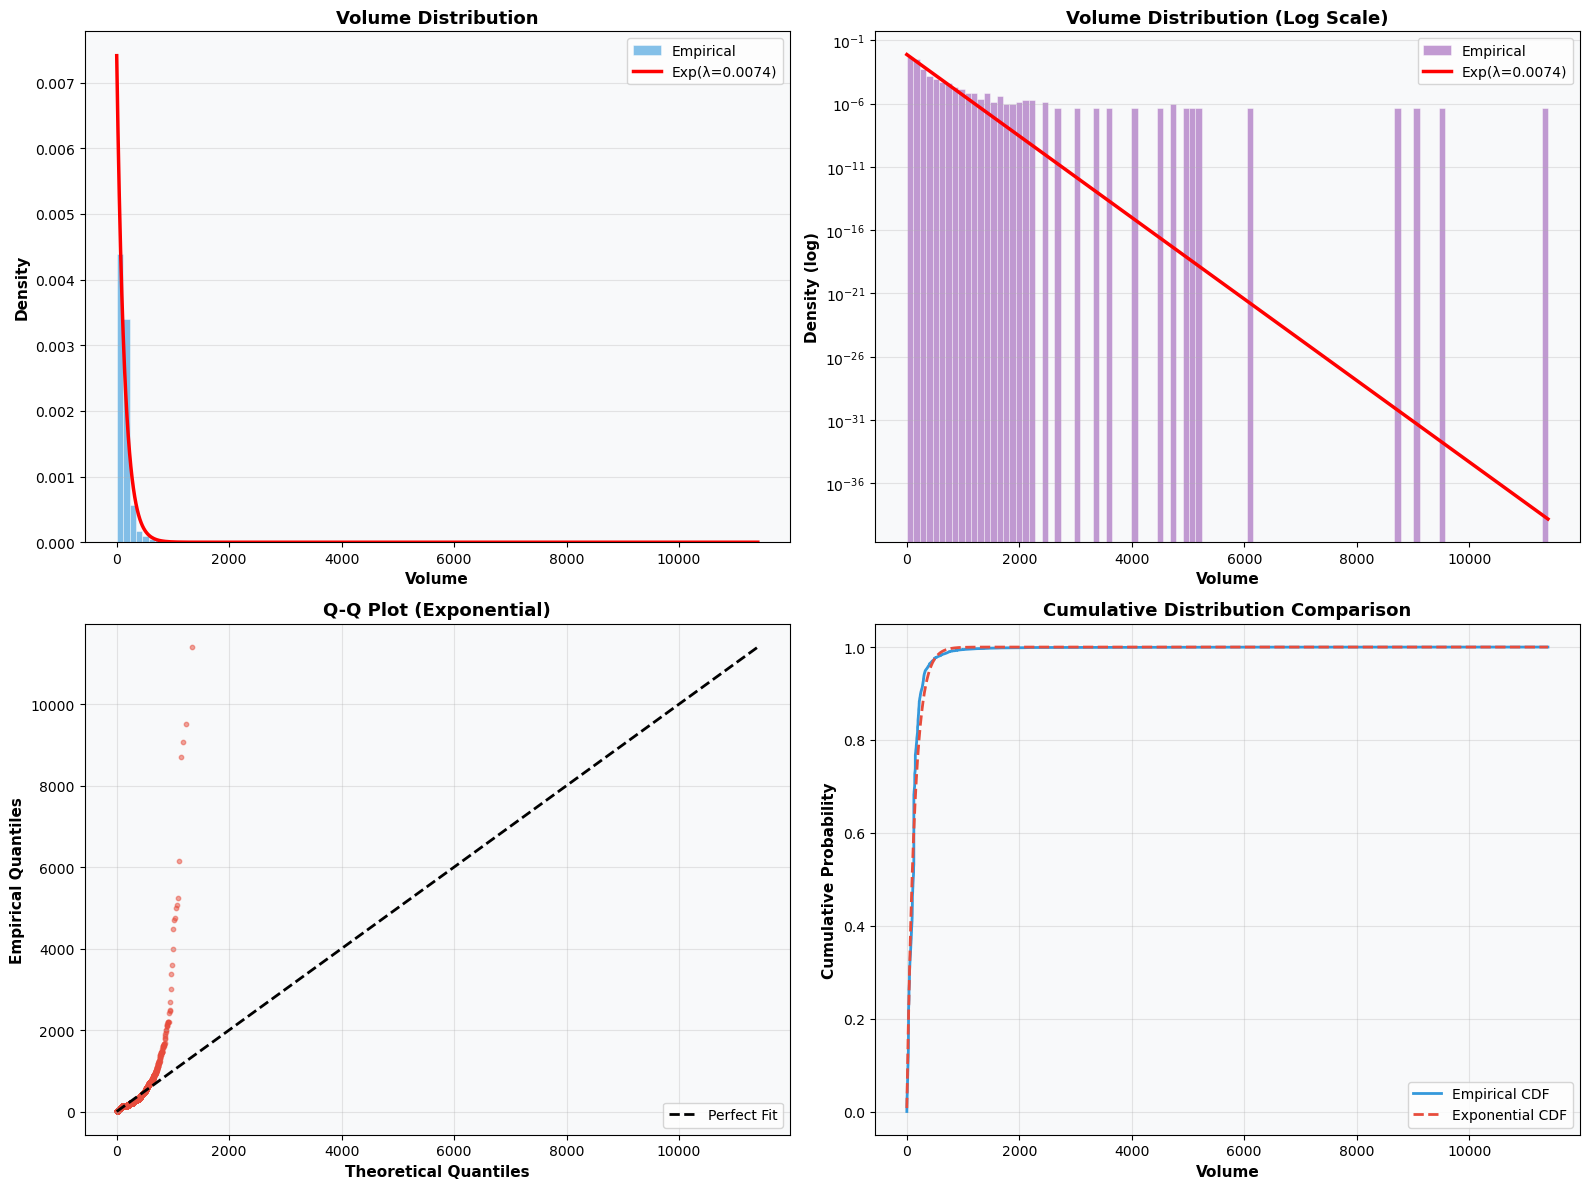


=== Goodness of Fit Statistics ===
Lambda (rate parameter): 0.007410
Mean (1/λ): 134.96
Empirical mean: 134.96

Kolmogorov-Smirnov Test:
  KS Statistic: 0.092752
  P-value: 0.000000
  → Reject exponential distribution (poor fit)


In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(volumes_pos, bins=100, density=True, 
                alpha=0.6, color='#3498DB', edgecolor='white', linewidth=0.5,
                label='Empirical')
x_range = np.linspace(0, volumes_pos.max(), 500)
axes[0, 0].plot(x_range, lamb_mle * np.exp(-lamb_mle * x_range), 
                'r-', linewidth=2.5, label=f'Exp(λ={lamb_mle:.4f})')
axes[0, 0].set_title('Volume Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Volume', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_facecolor('#F8F9FA')

axes[0, 1].hist(volumes_pos, bins=100, density=True, 
                alpha=0.6, color='#9B59B6', edgecolor='white', linewidth=0.5,
                label='Empirical')
axes[0, 1].plot(x_range, lamb_mle * np.exp(-lamb_mle * x_range), 
                'r-', linewidth=2.5, label=f'Exp(λ={lamb_mle:.4f})')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Volume Distribution (Log Scale)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Volume', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Density (log)', fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_facecolor('#F8F9FA')

sorted_volumes = np.sort(volumes_pos)
n_points = len(sorted_volumes)
theoretical_quantiles = -np.log(1 - np.arange(1, n_points + 1) / (n_points + 1)) / lamb_mle

axes[1, 0].scatter(theoretical_quantiles, sorted_volumes, alpha=0.5, s=10, color='#E74C3C')

max_val = max(theoretical_quantiles.max(), sorted_volumes.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Perfect Fit')
axes[1, 0].set_title('Q-Q Plot (Exponential)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Theoretical Quantiles', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Empirical Quantiles', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_facecolor('#F8F9FA')

empirical_cdf = np.arange(1, n_points + 1) / n_points
theoretical_cdf = 1 - np.exp(-lamb_mle * sorted_volumes)

axes[1, 1].plot(sorted_volumes, empirical_cdf, linewidth=2, 
                color='#3498DB', label='Empirical CDF')
axes[1, 1].plot(sorted_volumes, theoretical_cdf, linewidth=2, 
                color='#E74C3C', linestyle='--', label='Exponential CDF')
axes[1, 1].set_title('Cumulative Distribution Comparison', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Volume', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

ks_statistic, ks_pvalue = stats.kstest(volumes_pos, 
                                        lambda x: stats.expon.cdf(x, scale=1/lamb_mle))

print("\n=== Goodness of Fit Statistics ===")
print(f"Lambda (rate parameter): {lamb_mle:.6f}")
print(f"Mean (1/λ): {1/lamb_mle:.2f}")
print(f"Empirical mean: {volumes_pos.mean():.2f}")
print(f"\nKolmogorov-Smirnov Test:")
print(f"  KS Statistic: {ks_statistic:.6f}")
print(f"  P-value: {ks_pvalue:.6f}")
if ks_pvalue > 0.05:
    print("  → Cannot reject exponential distribution (good fit)")
else:
    print("  → Reject exponential distribution (poor fit)")

## 1.4 Volatility and traded volume

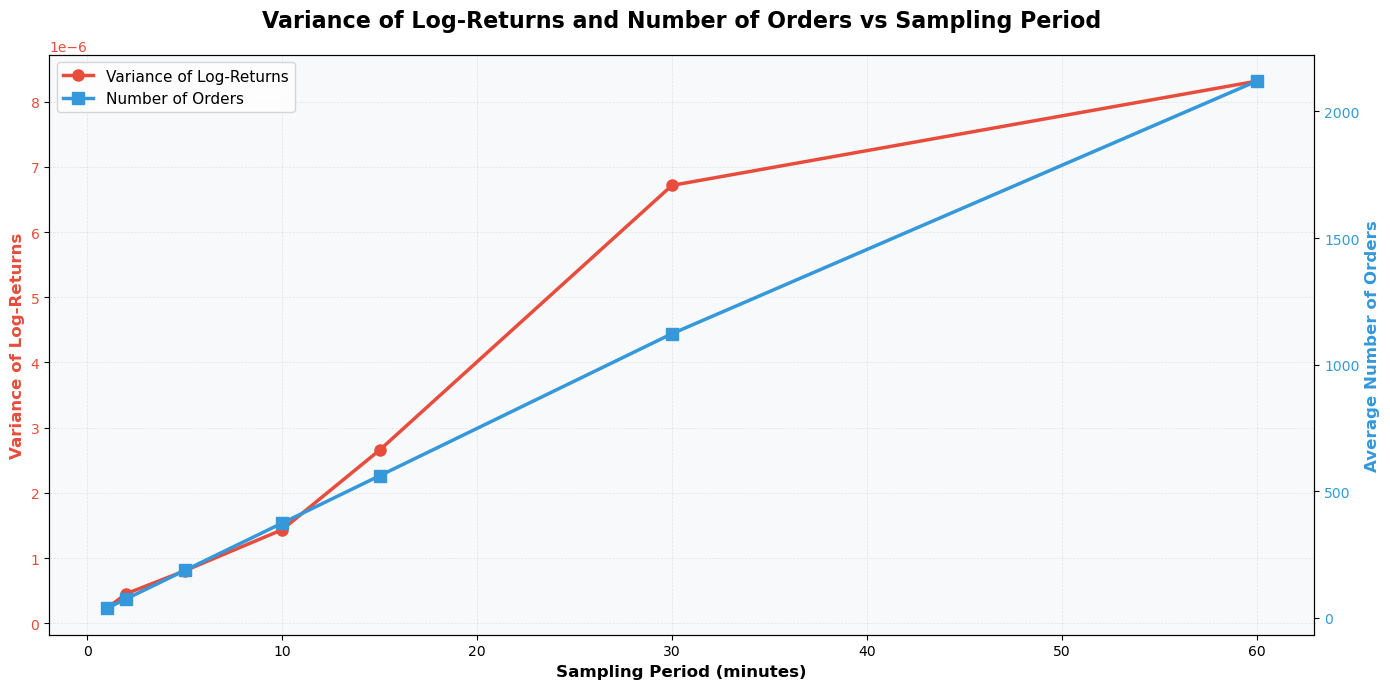

=== Variance and Number of Orders by Sampling Period ===
  1 min: Variance = 0.00000023, Avg # Orders = 37.48
  2 min: Variance = 0.00000045, Avg # Orders = 74.81
  5 min: Variance = 0.00000081, Avg # Orders = 187.02
 10 min: Variance = 0.00000144, Avg # Orders = 374.04
 15 min: Variance = 0.00000266, Avg # Orders = 561.06
 30 min: Variance = 0.00000672, Avg # Orders = 1122.12
 60 min: Variance = 0.00000831, Avg # Orders = 2119.56


In [34]:
df0['log_price'] = np.log(df0['price'])
df0['log_return'] = df0['log_price'].diff()

sampling_periods = [1, 2, 5, 10, 15, 30, 60]  
variances = []
num_orders = []

for period in sampling_periods:
    resampled = df0.resample(f'{period}min').agg({
        'log_price': 'last',
        'qty': 'count'  
    }).dropna()
    
    resampled_log_returns = resampled['log_price'].diff().dropna()
    var = resampled_log_returns.var()
    variances.append(var)

    avg_num_orders = resampled['qty'].mean()
    num_orders.append(avg_num_orders)

fig, ax1 = plt.subplots(figsize=(14, 7))

color1 = '#E74C3C'
ax1.set_xlabel('Sampling Period (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Variance of Log-Returns', fontsize=12, fontweight='bold', color=color1)
line1 = ax1.plot(sampling_periods, variances, 'o-', color=color1, 
                 linewidth=2.5, markersize=8, label='Variance of Log-Returns')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_facecolor('#F8F9FA')

ax2 = ax1.twinx()
color2 = '#3498DB'
ax2.set_ylabel('Average Number of Orders', fontsize=12, fontweight='bold', color=color2)
line2 = ax2.plot(sampling_periods, num_orders, 's-', color=color2, 
                 linewidth=2.5, markersize=8, label='Number of Orders')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Variance of Log-Returns and Number of Orders vs Sampling Period', 
          fontsize=16, fontweight='bold', pad=20)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

print("=== Variance and Number of Orders by Sampling Period ===")
for period, var, n_ord in zip(sampling_periods, variances, num_orders):
    print(f"{period:3d} min: Variance = {var:.8f}, Avg # Orders = {n_ord:.2f}")

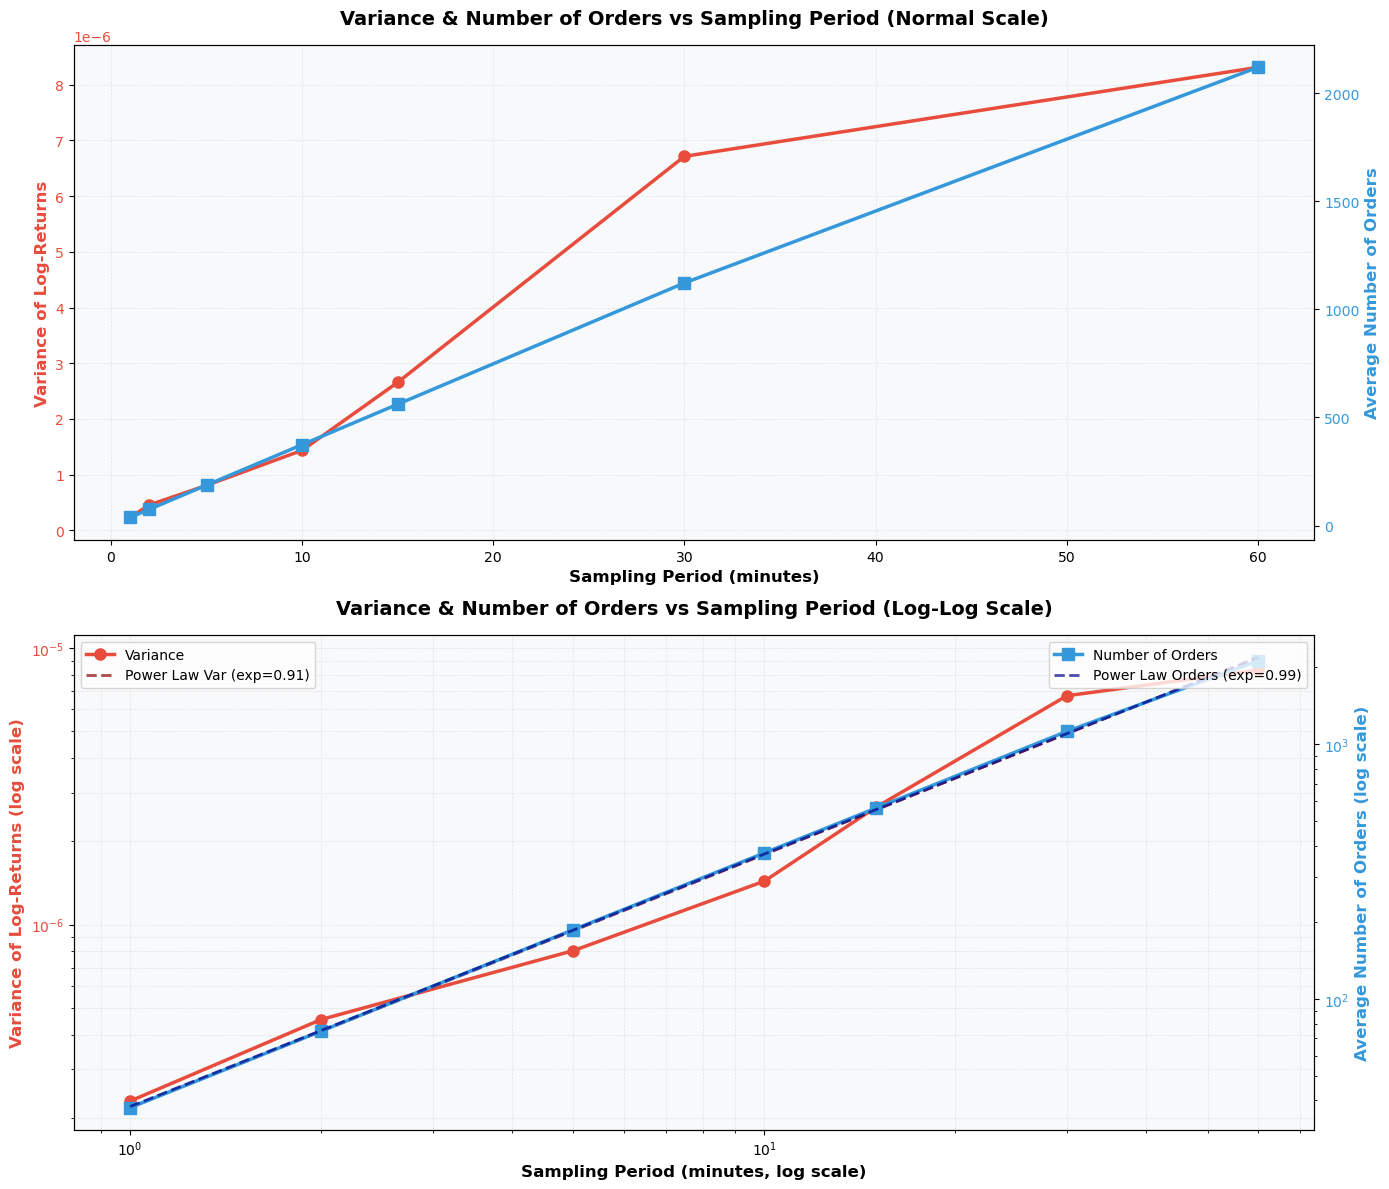


=== Power Law Analysis ===
Variance ~ Period^0.915
Number of Orders ~ Period^0.991

Variance Interpretation:
  → Close to linear scaling (Brownian motion behavior)

Orders Interpretation:
  → Linear growth: uniform order arrival rate

=== Variance and Number of Orders by Sampling Period ===
  1 min: Variance = 0.00000023, Avg # Orders = 37.48
  2 min: Variance = 0.00000045, Avg # Orders = 74.81
  5 min: Variance = 0.00000081, Avg # Orders = 187.02
 10 min: Variance = 0.00000144, Avg # Orders = 374.04
 15 min: Variance = 0.00000266, Avg # Orders = 561.06
 30 min: Variance = 0.00000672, Avg # Orders = 1122.12
 60 min: Variance = 0.00000831, Avg # Orders = 2119.56


In [35]:
df0['log_price'] = np.log(df0['price'])
df0['log_return'] = df0['log_price'].diff()

sampling_periods = [1, 2, 5, 10, 15, 30, 60]  
variances = []
num_orders = []

for period in sampling_periods:
    resampled = df0.resample(f'{period}min').agg({
        'log_price': 'last',
        'qty': 'count'  
    }).dropna()
    
    resampled_log_returns = resampled['log_price'].diff().dropna()
    var = resampled_log_returns.var()
    variances.append(var)

    avg_num_orders = resampled['qty'].mean()
    num_orders.append(avg_num_orders)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

ax1 = axes[0]
color1 = '#E74C3C'
ax1.set_xlabel('Sampling Period (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Variance of Log-Returns', fontsize=12, fontweight='bold', color=color1)
ax1.plot(sampling_periods, variances, 'o-', color=color1, 
         linewidth=2.5, markersize=8, label='Variance')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_facecolor('#F8F9FA')

ax2 = ax1.twinx()
color2 = '#3498DB'
ax2.set_ylabel('Average Number of Orders', fontsize=12, fontweight='bold', color=color2)
ax2.plot(sampling_periods, num_orders, 's-', color=color2, 
         linewidth=2.5, markersize=8, label='Number of Orders')
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_title('Variance & Number of Orders vs Sampling Period (Normal Scale)', 
              fontsize=14, fontweight='bold', pad=15)

ax3 = axes[1]
color1 = '#E74C3C'
ax3.set_xlabel('Sampling Period (minutes, log scale)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Variance of Log-Returns (log scale)', fontsize=12, fontweight='bold', color=color1)
ax3.loglog(sampling_periods, variances, 'o-', color=color1, 
           linewidth=2.5, markersize=8, label='Variance')
ax3.tick_params(axis='y', labelcolor=color1)
ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, which='both')
ax3.set_facecolor('#F8F9FA')

log_periods = np.log(sampling_periods)
log_variances = np.log(variances)
slope_var, intercept_var = np.polyfit(log_periods, log_variances, 1)
fit_variances = np.exp(intercept_var) * np.array(sampling_periods)**slope_var
ax3.plot(sampling_periods, fit_variances, '--', color='darkred', 
         linewidth=2, alpha=0.7, label=f'Power Law Var (exp={slope_var:.2f})')

ax4 = ax3.twinx()
color2 = '#3498DB'
ax4.set_ylabel('Average Number of Orders (log scale)', fontsize=12, fontweight='bold', color=color2)
ax4.loglog(sampling_periods, num_orders, 's-', color=color2, 
           linewidth=2.5, markersize=8, label='Number of Orders')
ax4.tick_params(axis='y', labelcolor=color2)

log_orders = np.log(num_orders)
slope_ord, intercept_ord = np.polyfit(log_periods, log_orders, 1)
fit_orders = np.exp(intercept_ord) * np.array(sampling_periods)**slope_ord
ax4.plot(sampling_periods, fit_orders, '--', color='darkblue', 
         linewidth=2, alpha=0.7, label=f'Power Law Orders (exp={slope_ord:.2f})')

ax3.set_title('Variance & Number of Orders vs Sampling Period (Log-Log Scale)', 
              fontsize=14, fontweight='bold', pad=15)

lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines1, labels1, loc='upper left', fontsize=10)
ax4.legend(lines2, labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n=== Power Law Analysis ===")
print(f"Variance ~ Period^{slope_var:.3f}")
print(f"Number of Orders ~ Period^{slope_ord:.3f}")
print(f"\nVariance Interpretation:")
if abs(slope_var - 1.0) < 0.1:
    print("  → Close to linear scaling (Brownian motion behavior)")
elif slope_var > 1:
    print("  → Super-diffusive behavior")
else:
    print("  → Sub-diffusive behavior")
print(f"\nOrders Interpretation:")
if abs(slope_ord - 1.0) < 0.1:
    print("  → Linear growth: uniform order arrival rate")
elif slope_ord > 1:
    print("  → Super-linear: order clustering at longer timescales")
else:
    print("  → Sub-linear: order dispersion")

print("\n=== Variance and Number of Orders by Sampling Period ===")
for period, var, n_ord in zip(sampling_periods, variances, num_orders):
    print(f"{period:3d} min: Variance = {var:.8f}, Avg # Orders = {n_ord:.2f}")

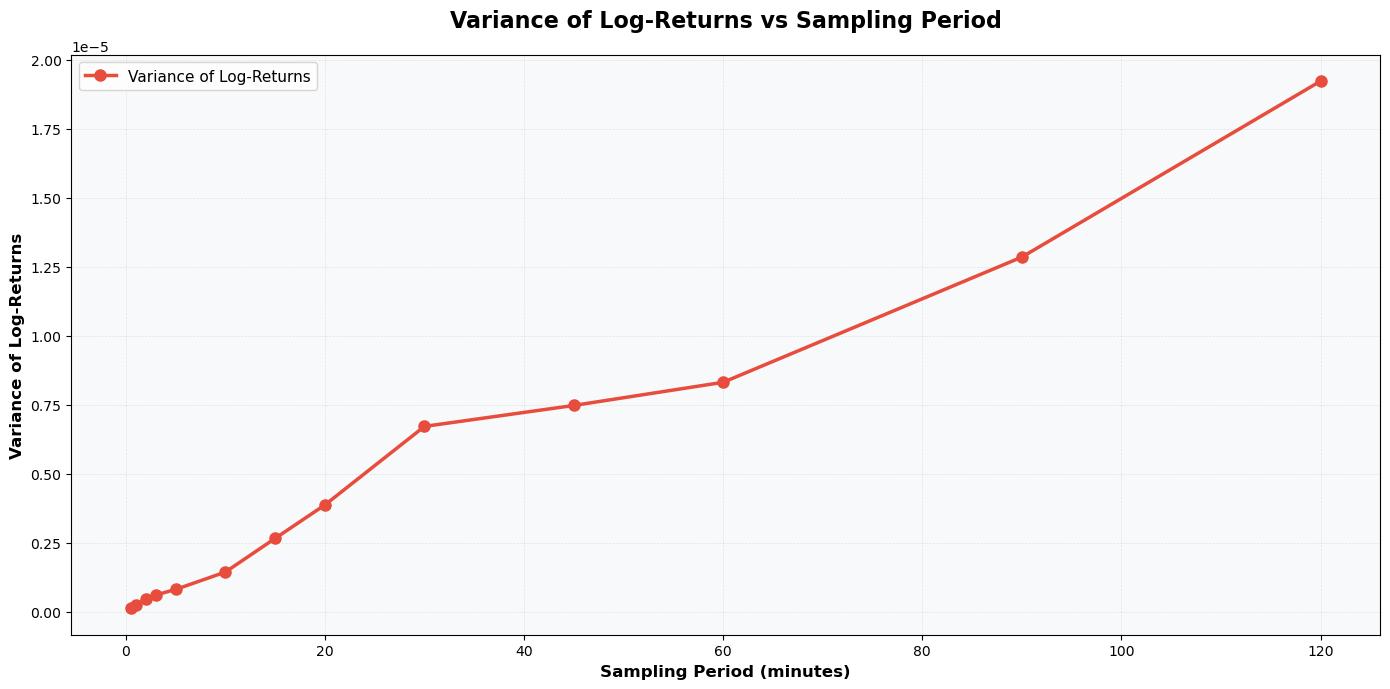

=== Variance by Sampling Period ===
   0.5 min: Variance = 0.00000012
   1.0 min: Variance = 0.00000023
   2.0 min: Variance = 0.00000045
   3.0 min: Variance = 0.00000060
   5.0 min: Variance = 0.00000081
  10.0 min: Variance = 0.00000144
  15.0 min: Variance = 0.00000266
  20.0 min: Variance = 0.00000387
  30.0 min: Variance = 0.00000672
  45.0 min: Variance = 0.00000747
  60.0 min: Variance = 0.00000831
  90.0 min: Variance = 0.00001285
 120.0 min: Variance = 0.00001923


In [36]:
if 'log_price' not in df0.columns:
    df0['log_price'] = np.log(df0['price'])

sampling_periods = [0.5, 1, 2, 3, 5, 10, 15, 20, 30, 45, 60, 90, 120]
variances = []

for period in sampling_periods:
    if period < 1:
        freq_str = f'{int(period*60)}s'
    else:
        freq_str = f'{int(period)}min'
    
    resampled = df0['log_price'].resample(freq_str).last().dropna()
    
    if len(resampled) > 2:  
        log_returns = resampled.diff().dropna()
        var = log_returns.var()
        variances.append(var)
    else:
        variances.append(np.nan)

valid_indices = ~np.isnan(variances)
sampling_periods_clean = np.array(sampling_periods)[valid_indices]
variances_clean = np.array(variances)[valid_indices]

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(sampling_periods_clean, variances_clean, 'o-', color='#E74C3C', 
        linewidth=2.5, markersize=8, label='Variance of Log-Returns')

ax.set_title('Variance of Log-Returns vs Sampling Period', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sampling Period (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Variance of Log-Returns', fontsize=12, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_facecolor('#F8F9FA')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("=== Variance by Sampling Period ===")
for period, var in zip(sampling_periods_clean, variances_clean):
    print(f"{period:6.1f} min: Variance = {var:.8f}")

## 1.5 High Frequency Data


Sampling: 1 minutes
Event Time:    μ = 0.00002313, σ = 0.00048007
               Skewness = -0.0869
               Kurtosis = 2.1437
Calendar Time: μ = 0.00002309, σ = 0.00047913
               N_obs = 508

Sampling: 5 minutes
Event Time:    μ = 0.00012535, σ = 0.00089757
               Skewness = 0.5247
               Kurtosis = 2.1781
Calendar Time: μ = 0.00012535, σ = 0.00089312
               N_obs = 101

Sampling: 15 minutes
Event Time:    μ = 0.00031204, σ = 0.00162982
               Skewness = 0.0958
               Kurtosis = 1.2910
Calendar Time: μ = 0.00031204, σ = 0.00160494
               N_obs = 33

Sampling: 30 minutes
Event Time:    μ = 0.00054152, σ = 0.00259134
               Skewness = 0.8605
               Kurtosis = 2.4087
Calendar Time: μ = 0.00054152, σ = 0.00250906
               N_obs = 16

Sampling: 60 minutes
Event Time:    μ = 0.00015736, σ = 0.00288330
               Skewness = -0.9873
               Kurtosis = 0.7670
Calendar Time: μ = 0.00015736, σ = 0.002

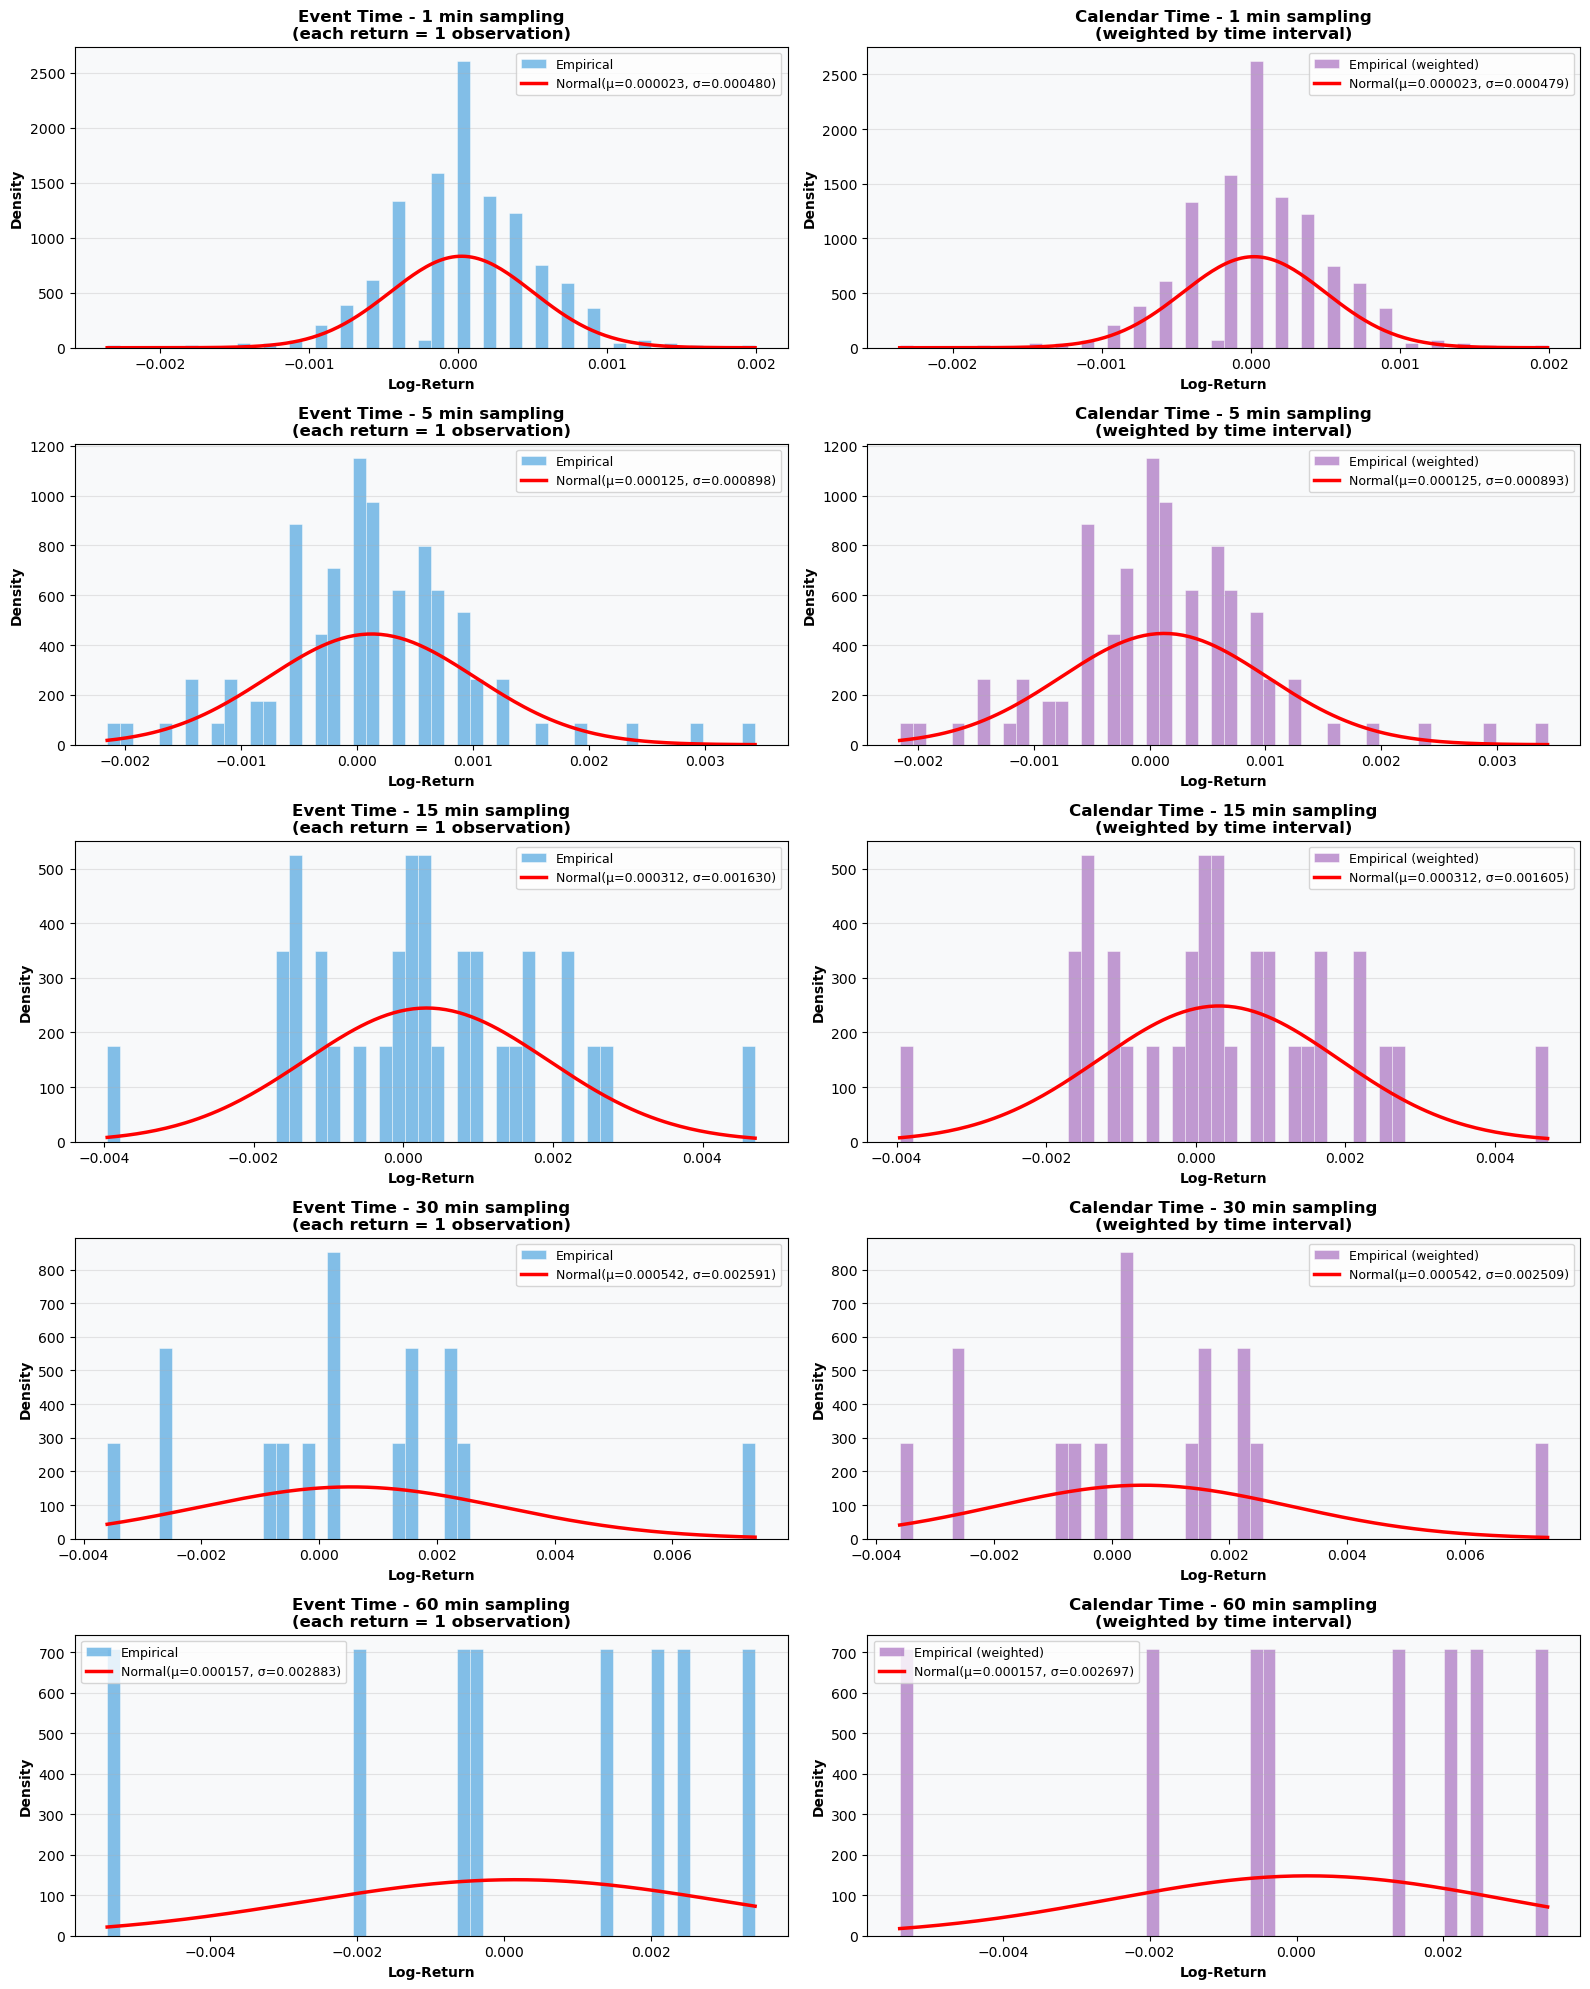

In [37]:
sampling_freqs = [1, 5, 15, 30, 60]  

fig, axes = plt.subplots(len(sampling_freqs), 2, figsize=(16, 4*len(sampling_freqs)))

for idx, freq in enumerate(sampling_freqs):
    freq_str = f'{freq}min'
    
    resampled = df0.resample(freq_str).agg({
        'log_price': 'last'
    }).dropna()
    
    log_returns = resampled['log_price'].diff().dropna()

    ax_event = axes[idx, 0]

    n, bins, patches = ax_event.hist(log_returns, bins=50, density=True, 
                                      alpha=0.6, color='#3498DB', 
                                      edgecolor='white', linewidth=0.5,
                                      label='Empirical')
    
    mu_event, sigma_event = log_returns.mean(), log_returns.std()
    x_range = np.linspace(log_returns.min(), log_returns.max(), 200)
    normal_fit = stats.norm.pdf(x_range, mu_event, sigma_event)
    ax_event.plot(x_range, normal_fit, 'r-', linewidth=2.5, 
                  label=f'Normal(μ={mu_event:.6f}, σ={sigma_event:.6f})')
    
    ax_event.set_title(f'Event Time - {freq} min sampling\n(each return = 1 observation)', 
                       fontsize=12, fontweight='bold')
    ax_event.set_xlabel('Log-Return', fontsize=10, fontweight='bold')
    ax_event.set_ylabel('Density', fontsize=10, fontweight='bold')
    ax_event.legend(fontsize=9)
    ax_event.grid(True, alpha=0.3, axis='y')
    ax_event.set_facecolor('#F8F9FA')
    
    ax_calendar = axes[idx, 1]
    
    time_deltas = resampled.index.to_series().diff().dt.total_seconds() / 60  
    time_deltas = time_deltas[1:]  
    
    weights = time_deltas / time_deltas.sum()
    
    ax_calendar.hist(log_returns, bins=50, density=True, weights=weights,
                     alpha=0.6, color='#9B59B6', 
                     edgecolor='white', linewidth=0.5,
                     label='Empirical (weighted)')
    
    mu_calendar = np.average(log_returns, weights=weights)
    sigma_calendar = np.sqrt(np.average((log_returns - mu_calendar)**2, weights=weights))
    normal_fit_weighted = stats.norm.pdf(x_range, mu_calendar, sigma_calendar)
    ax_calendar.plot(x_range, normal_fit_weighted, 'r-', linewidth=2.5,
                     label=f'Normal(μ={mu_calendar:.6f}, σ={sigma_calendar:.6f})')
    
    ax_calendar.set_title(f'Calendar Time - {freq} min sampling\n(weighted by time interval)', 
                          fontsize=12, fontweight='bold')
    ax_calendar.set_xlabel('Log-Return', fontsize=10, fontweight='bold')
    ax_calendar.set_ylabel('Density', fontsize=10, fontweight='bold')
    ax_calendar.legend(fontsize=9)
    ax_calendar.grid(True, alpha=0.3, axis='y')
    ax_calendar.set_facecolor('#F8F9FA')
    
    print(f"\n{'='*60}")
    print(f"Sampling: {freq} minutes")
    print(f"{'='*60}")
    print(f"Event Time:    μ = {mu_event:.8f}, σ = {sigma_event:.8f}")
    print(f"               Skewness = {log_returns.skew():.4f}")
    print(f"               Kurtosis = {log_returns.kurtosis():.4f}")
    print(f"Calendar Time: μ = {mu_calendar:.8f}, σ = {sigma_calendar:.8f}")
    print(f"               N_obs = {len(log_returns)}")

plt.tight_layout()
plt.show()

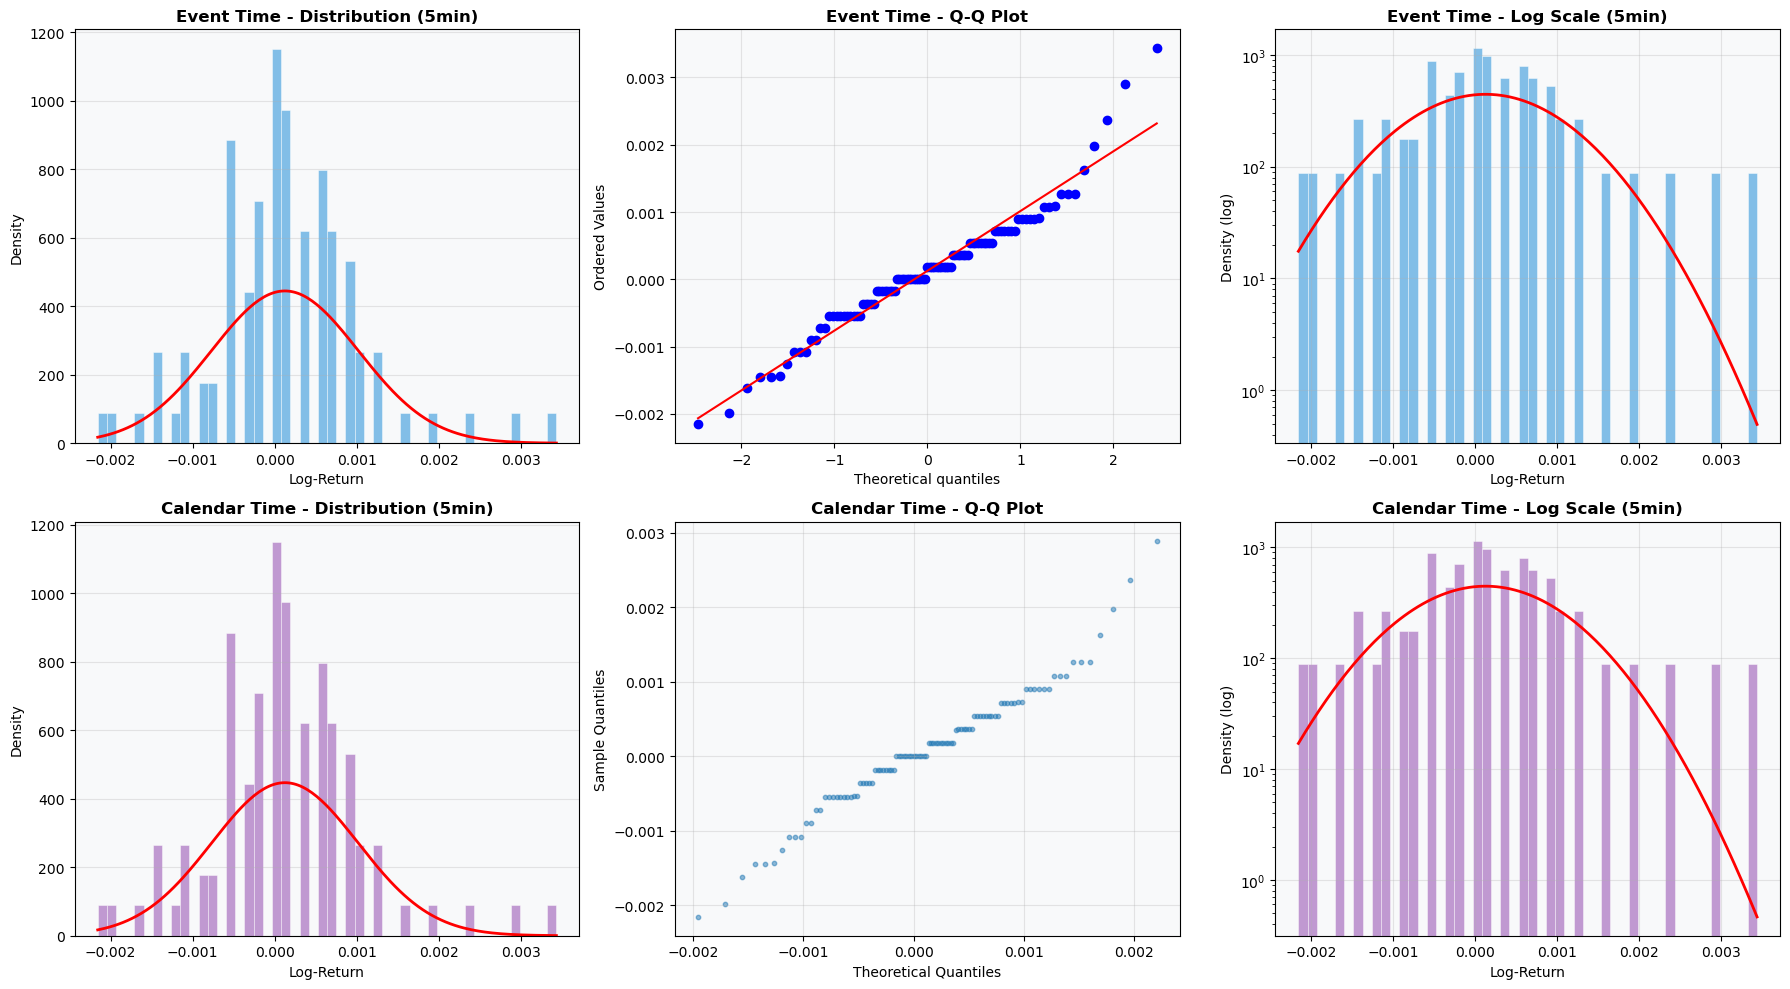

In [38]:
freq = 5  
freq_str = f'{freq}min'

resampled = df0.resample(freq_str).agg({'log_price': 'last'}).dropna()
log_returns = resampled['log_price'].diff().dropna()
time_deltas = resampled.index.to_series().diff().dt.total_seconds()[1:] / 60
weights = time_deltas / time_deltas.sum()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].hist(log_returns, bins=50, density=True, alpha=0.6, 
                color='#3498DB', edgecolor='white', linewidth=0.5)
mu_e, sigma_e = log_returns.mean(), log_returns.std()
x = np.linspace(log_returns.min(), log_returns.max(), 200)
axes[0, 0].plot(x, stats.norm.pdf(x, mu_e, sigma_e), 'r-', linewidth=2)
axes[0, 0].set_title(f'Event Time - Distribution ({freq}min)', fontweight='bold')
axes[0, 0].set_xlabel('Log-Return')
axes[0, 0].set_ylabel('Density')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_facecolor('#F8F9FA')

stats.probplot(log_returns, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Event Time - Q-Q Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_facecolor('#F8F9FA')

axes[0, 2].hist(log_returns, bins=50, density=True, alpha=0.6,
                color='#3498DB', edgecolor='white', linewidth=0.5)
axes[0, 2].plot(x, stats.norm.pdf(x, mu_e, sigma_e), 'r-', linewidth=2)
axes[0, 2].set_yscale('log')
axes[0, 2].set_title(f'Event Time - Log Scale ({freq}min)', fontweight='bold')
axes[0, 2].set_xlabel('Log-Return')
axes[0, 2].set_ylabel('Density (log)')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_facecolor('#F8F9FA')

axes[1, 0].hist(log_returns, bins=50, density=True, weights=weights,
                alpha=0.6, color='#9B59B6', edgecolor='white', linewidth=0.5)
mu_c = np.average(log_returns, weights=weights)
sigma_c = np.sqrt(np.average((log_returns - mu_c)**2, weights=weights))
axes[1, 0].plot(x, stats.norm.pdf(x, mu_c, sigma_c), 'r-', linewidth=2)
axes[1, 0].set_title(f'Calendar Time - Distribution ({freq}min)', fontweight='bold')
axes[1, 0].set_xlabel('Log-Return')
axes[1, 0].set_ylabel('Density')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_facecolor('#F8F9FA')

sorted_returns = np.sort(log_returns)
sorted_weights = weights.values[np.argsort(log_returns)]
cumulative_weights = np.cumsum(sorted_weights)
theoretical_quantiles = stats.norm.ppf(cumulative_weights, mu_c, sigma_c)
axes[1, 1].scatter(theoretical_quantiles, sorted_returns, alpha=0.5, s=10)
axes[1, 1].plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
                [theoretical_quantiles.min(), theoretical_quantiles.max()], 
                'r--', linewidth=2)
axes[1, 1].set_title('Calendar Time - Q-Q Plot', fontweight='bold')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_facecolor('#F8F9FA')

axes[1, 2].hist(log_returns, bins=50, density=True, weights=weights,
                alpha=0.6, color='#9B59B6', edgecolor='white', linewidth=0.5)
axes[1, 2].plot(x, stats.norm.pdf(x, mu_c, sigma_c), 'r-', linewidth=2)
axes[1, 2].set_yscale('log')
axes[1, 2].set_title(f'Calendar Time - Log Scale ({freq}min)', fontweight='bold')
axes[1, 2].set_xlabel('Log-Return')
axes[1, 2].set_ylabel('Density (log)')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

# Question 2 : Quotes

## 2.1 Dataset

In [39]:
df0 = open_convert_data("stock0_day0_updates.csv.gz")
df1 = open_convert_data("stock1_day0_updates.csv.gz")
df2 = open_convert_data("stock2_day0_updates.csv.gz")

In [40]:
def lob_basic_checks(df):
    checks = {}

    checks["n_updates"] = len(df)

    checks["missing_bp"] = df["bp"].isna().mean()
    checks["missing_ap"] = df["ap"].isna().mean()
    checks["missing_bq"] = df["bq"].isna().mean()
    checks["missing_aq"] = df["aq"].isna().mean()

    checks["non_positive_bp"] = (df["bp"] <= 0).sum()
    checks["non_positive_ap"] = (df["ap"] <= 0).sum()

    # Bid should always be <= ask
    checks["crossed_books"] = (df["bp"] > df["ap"]).sum()

    return pd.Series(checks)

In [41]:
df0

,type,bp,bq,ap,aq
ts,,,,,
2026-01-26 09:00:00.340497,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503532,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503539,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503565,U,NaN,19671.0,NaN,24789.0
2026-01-26 09:00:00.503735,U,NaN,19671.0,NaN,24789.0
...,...,...,...,...,...
2026-01-26 17:29:58.696978,U,55.63,337.0,55.65,462.0
2026-01-26 17:29:58.697298,U,55.63,557.0,55.65,462.0
2026-01-26 17:29:59.044651,U,55.63,517.0,55.65,462.0


In [42]:
lob_basic_checks(df0)

n_updates          226217.000000
missing_bp              0.000393
missing_ap              0.000393
missing_bq              0.000000
missing_aq              0.000000
non_positive_bp         0.000000
non_positive_ap         0.000000
crossed_books           0.000000
dtype: float64

In [43]:
df1

,type,bp,bq,ap,aq
ts,,,,,
2026-01-26 09:00:00.050343,U,NaN,2961.0,NaN,1912.0
2026-01-26 09:00:00.087730,U,NaN,2961.0,NaN,1912.0
2026-01-26 09:00:00.093528,U,NaN,2961.0,NaN,1912.0
2026-01-26 09:00:00.133887,U,NaN,2961.0,NaN,1912.0
2026-01-26 09:00:00.134330,U,NaN,2958.0,NaN,1912.0
...,...,...,...,...,...
2026-01-26 17:29:59.251404,U,26.715,205.0,26.725,27.0
2026-01-26 17:29:59.252771,U,26.715,205.0,26.725,188.0
2026-01-26 17:29:59.252808,U,26.710,317.0,26.725,188.0


In [44]:
df2

,type,bp,bq,ap,aq
ts,,,,,
2026-01-26 09:00:00.048442,U,NaN,22590.0,NaN,3666.0
2026-01-26 09:00:00.071613,U,NaN,22590.0,NaN,3666.0
2026-01-26 09:00:00.071618,U,NaN,22590.0,NaN,3666.0
2026-01-26 09:00:00.071673,U,NaN,22590.0,NaN,3666.0
2026-01-26 09:00:00.071689,U,NaN,22590.0,NaN,3666.0
...,...,...,...,...,...
2026-01-26 17:29:55.613839,U,53.33,805.0,53.36,800.0
2026-01-26 17:29:55.613878,U,53.33,835.0,53.36,800.0
2026-01-26 17:29:56.845833,U,53.33,868.0,53.36,800.0


In [45]:
df1.describe()

,bp,bq,ap,aq
count,73581.000000,73947.000000,73581.000000,73947.000000
mean,26.475909,367.620999,26.489311,420.093621
std,0.178777,371.052801,0.175179,487.450106
min,26.000000,1.000000,26.030000,1.000000
25%,26.340000,196.000000,26.355000,207.000000
50%,26.460000,287.000000,26.470000,310.000000
75%,26.620000,480.000000,26.630000,540.000000
max,26.840000,7804.000000,26.850000,13731.000000


In [46]:
df0.describe()

,bp,bq,ap,aq
count,226128.000000,226217.000000,226128.000000,226217.000000
mean,55.415979,686.646393,55.429111,938.348183
std,0.151465,910.275112,0.150203,1029.520042
min,54.830000,1.000000,54.870000,1.000000
25%,55.330000,308.000000,55.340000,344.000000
50%,55.400000,573.000000,55.410000,701.000000
75%,55.530000,901.000000,55.540000,1253.000000
max,55.740000,31820.000000,55.750000,25516.000000


In [47]:
df2.describe()

,bp,bq,ap,aq
count,212559.000000,212731.000000,212559.000000,212731.000000
mean,53.540530,587.327164,53.554989,622.253771
std,0.166649,808.682521,0.165288,560.670071
min,52.860000,1.000000,52.900000,1.000000
25%,53.440000,236.000000,53.450000,239.000000
50%,53.540000,427.000000,53.550000,476.000000
75%,53.680000,785.000000,53.690000,850.000000
max,53.850000,22590.000000,53.870000,8247.000000


In [48]:
df0.isna().sum()

type     0
bp      89
bq       0
ap      89
aq       0
dtype: int64

In [49]:
df1.isna().sum()

type      0
bp      366
bq        0
ap      366
aq        0
dtype: int64

In [50]:
df2.isna().sum()

type      0
bp      172
bq        0
ap      172
aq        0
dtype: int64

In [51]:
df0 = df0.dropna()
df1 = df1.dropna()
df2 = df2.dropna()

In [52]:
df0.isna().sum()

type    0
bp      0
bq      0
ap      0
aq      0
dtype: int64

In [53]:
df1.isna().sum()

type    0
bp      0
bq      0
ap      0
aq      0
dtype: int64

In [54]:
df2.isna().sum()

type    0
bp      0
bq      0
ap      0
aq      0
dtype: int64

## 2.2 Prices

In [55]:
def add_price_metrics(df):
    df = df.copy()

    df["mid_price"] = 0.5 * (df["bp"] + df["ap"])
    df["weighted_mid_price"] = (
        df["bp"] * df["aq"] + df["ap"] * df["bq"]
    ) / (df["aq"] + df["bq"])

    return df

In [56]:
def extract_5min_window(df):
    start_time = df.index.min()
    end_time = start_time + pd.Timedelta(minutes=5)

    return df.loc[start_time:end_time]

In [57]:
df0_prices = add_price_metrics(df0[df0["type"]!="T"])
df0_prices

,type,bp,bq,ap,aq,mid_price,weighted_mid_price
ts,,,,,,,
2026-01-26 09:00:27.018202,U,54.97,446.0,55.00,21087.0,54.985,54.970621
2026-01-26 09:00:27.018202,U,54.97,446.0,55.00,21085.0,54.985,54.970621
2026-01-26 09:00:27.018202,U,54.97,446.0,55.00,21075.0,54.985,54.970622
2026-01-26 09:00:27.018202,U,54.97,446.0,55.00,21065.0,54.985,54.970622
2026-01-26 09:00:27.024973,U,54.97,446.0,54.99,125.0,54.980,54.985622
...,...,...,...,...,...,...,...
2026-01-26 17:29:58.696978,U,55.63,337.0,55.65,462.0,55.640,55.638436
2026-01-26 17:29:58.697298,U,55.63,557.0,55.65,462.0,55.640,55.640932
2026-01-26 17:29:59.044651,U,55.63,517.0,55.65,462.0,55.640,55.640562


In [58]:
df0_prices = df0_prices.sort_index()
df0_roll = extract_5min_window(df0_prices)

In [59]:
df0_roll[["bp", "ap", "mid_price", "weighted_mid_price"]].head()

,bp,ap,mid_price,weighted_mid_price
ts,,,,
2026-01-26 09:00:27.018202,54.97,55.00,54.985,54.970621
2026-01-26 09:00:27.018202,54.97,55.00,54.985,54.970621
2026-01-26 09:00:27.018202,54.97,55.00,54.985,54.970622
2026-01-26 09:00:27.018202,54.97,55.00,54.985,54.970622
2026-01-26 09:00:27.024973,54.97,54.99,54.980,54.985622


In [60]:
def plot_lob_prices_5min(df, title="LOB prices – 5-minute window"):
    plt.figure(figsize=(12, 6))

    plt.plot(df.index, df["bp"], label="Best Bid", linewidth=1)
    plt.plot(df.index, df["ap"], label="Best Ask", linewidth=1)
    plt.plot(df.index, df["mid_price"], label="Mid Price", linewidth=2)
    plt.plot(
        df.index,
        df["weighted_mid_price"],
        label="Weighted Mid Price",
        linestyle="--",
        linewidth=2
    )

    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.fill_between(
    df0_roll.index,
    df0_roll["bp"],
    df0_roll["ap"],
    alpha=0.15,
    label="Spread"
    )

    plt.tight_layout()
    plt.show()

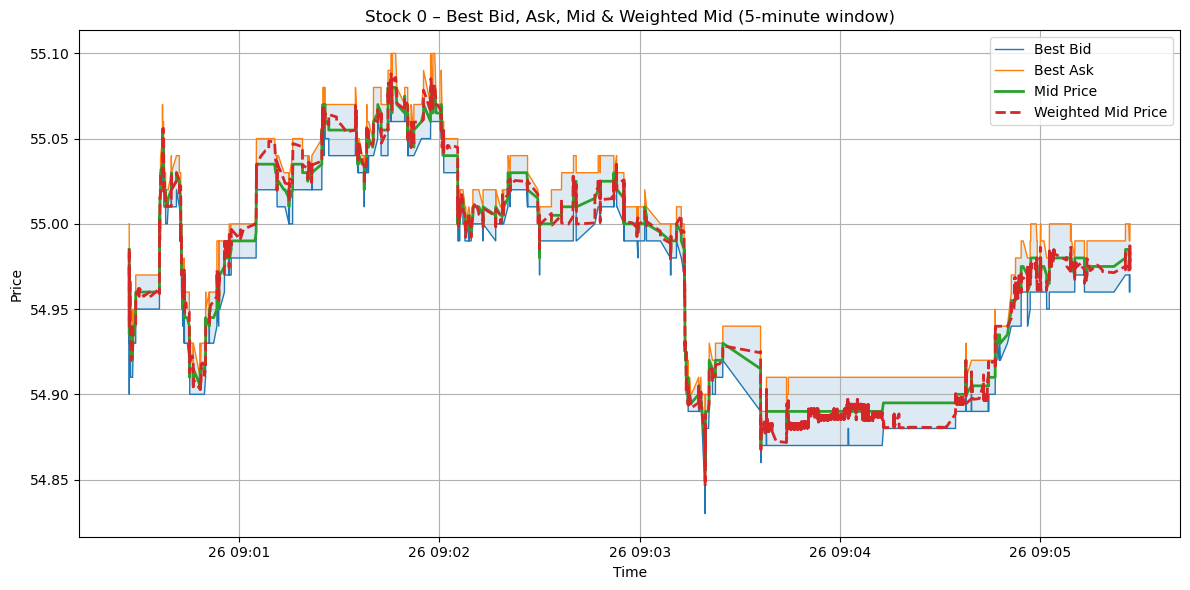

In [61]:
plot_lob_prices_5min(
    df0_roll,
    title="Stock 0 – Best Bid, Ask, Mid & Weighted Mid (5-minute window)"
)

## 2.3 Spread

In [62]:
def plot_spread_distribution_event_time(df, title):
    spread = df["spread"].dropna()

    plt.figure(figsize=(8, 5))
    plt.hist(spread, bins=50, density=True, alpha=0.7)
    plt.xlabel("Spread")
    plt.ylabel("Density")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return spread.describe()

In [63]:
def spread_calendar_time(df, freq="1s"):
    return (
        df["spread"]
        .resample(freq)
        .last()
        .dropna()
    )

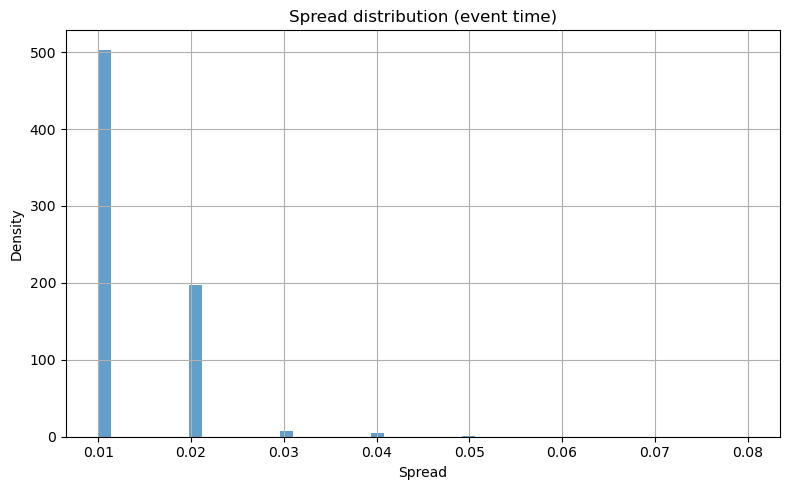

count    216539.000000
mean          0.013223
std           0.005389
min           0.010000
25%           0.010000
50%           0.010000
75%           0.020000
max           0.080000
Name: spread, dtype: float64


In [64]:
df0_prices = df0_prices.copy()
df0_prices["spread"] = df0_prices["ap"] - df0_prices["bp"]
stats_event = plot_spread_distribution_event_time(
    df0_prices,
    "Spread distribution (event time)"
)
print(stats_event)

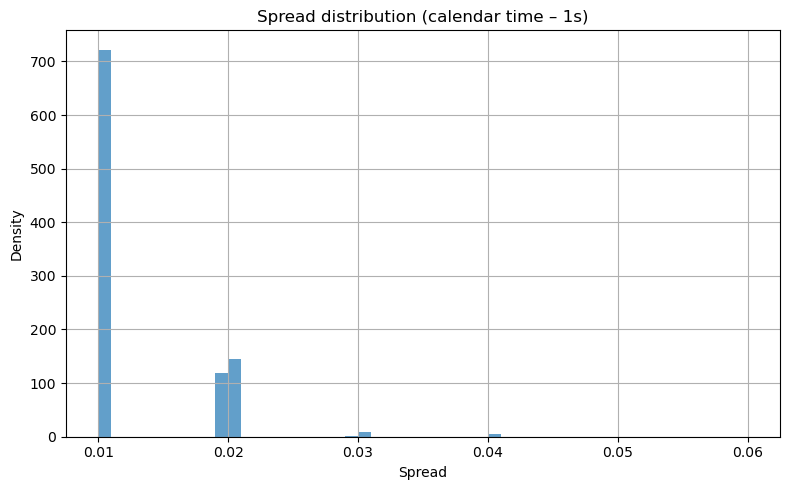

In [65]:
spread_ct = spread_calendar_time(df0_prices, freq="1s")

plt.figure(figsize=(8, 5))
plt.hist(spread_ct, bins=50, density=True, alpha=0.7)
plt.xlabel("Spread")
plt.ylabel("Density")
plt.title("Spread distribution (calendar time – 1s)")
plt.grid(True)
plt.tight_layout()
plt.show()

Large spread small tick it's consistent with what we've seen before

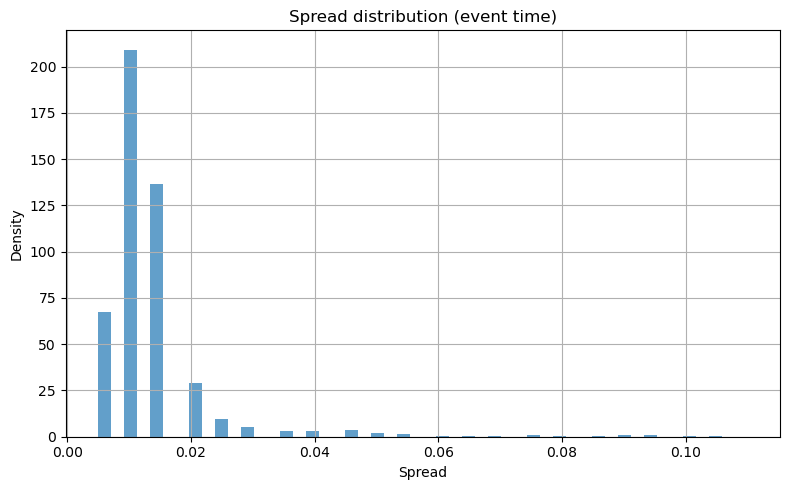

count    70425.000000
mean         0.013634
std          0.010346
min          0.005000
25%          0.010000
50%          0.010000
75%          0.015000
max          0.110000
Name: spread, dtype: float64


In [66]:
df1_prices = add_price_metrics(df1[df1["type"]!="T"])
df1_prices = df1_prices.copy()
df1_prices["spread"] = df1_prices["ap"] - df1_prices["bp"]
stats_event = plot_spread_distribution_event_time(
    df1_prices,
    "Spread distribution (event time)"
)
print(stats_event)